# Bidirectional LSTM -- Lei Fu

* __Author__: _Lei Fu_
* __Date__: April 26th, 2020


- <a>0. References</a>
    - <a> 0.1. Machine Learning for Subsurface Characterization
- <a>1. Introduction: Synthetic Sonic Curves Generation </a>
    - <a>1.1. Background</a>
    - <a>1.2. Problem Statement</a>
    - <a>1.3. Data Description</a>
    - <a>1.4. Evaluation Metric</a>
- <a>2. Imports</a>
- <a>3. Read in Data</a>
- <a>4. Glimpse of Data</a>
- <a>5. Exploratory Data Analysis</a>
- <a>6. Build Machine Models</a>
- <a>7. Prediction</a>
- <a>8. Summary</a>

<a></a>

## <a>0. References</a>

### <a>0.1. Machine Learning for Subsurface Characterization</a>

    https://books.google.com/books?hl=en&lr=&id=WdO1DwAAQBAJ&oi=fnd&pg=PA1&dq=Unsupervised+Outlier+Detection+Techniques+for+Well+Logs+and+Geophysical+Data&ots=bqx1qdGVIz&sig=6sUAVkNO4yxcD3NhszLhicyMMrc#v=onepage&q&f=false

## <a>1. Introduction: Synthetic Sonic Curves Generation</a>


### <a>1.1. Background</a>
Well logs are interpreted/processed to estimate the in-situ petrophysical and geomechanical properties, which is essential for subsurface characterization. Various types of logs exist, and each provides distinct information about subsurface properties. Certain well logs, like gamma ray (GR), resistivity, density, and neutron logs, are considered as “easy-to-acquire” conventional well logs that are run in most of the wells. Other well logs, like nuclear magnetic resonance, dielectric dispersion, elemental spectroscopy, and sometimes sonic logs, are only run in limited number of wells.

Sonic travel-time logs contain critical geomechanical information for subsurface characterization around the wellbore. Often, sonic logs are required to complete the well-seismic tie workflow or geomechanical properties prediction. When sonic logs are absent in a well or an interval, a common practice is to synthesize them based on its neighboring wells that have sonic logs. This is referred to as sonic log synthesis or pseudo sonic log generation.


### <a>1.2. Problem Statement</a>
Compressional travel-time (DTC) and shear travel-time (DTS) logs are not acquired in all the wells drilled in a field due to financial or operational constraints. Under such circumstances, machine learning techniques can be used to predict DTC and DTS logs to improve subsurface characterization. The goal of the “SPWLA’s 1st Petrophysical Data-Driven Analytics Contest” is to develop data-driven models by processing “easy-to-acquire” conventional logs from Well #1, and use the data-driven models to generate synthetic compressional and shear travel-time logs (DTC and DTS, respectively) in Well #2. A robust data-driven model for the desired sonic-log synthesis will result in low prediction errors, which can be quantified in terms of Root Mean Squared Error by comparing the synthesized and the original DTC and DTS logs.

You are provided with two datasets: train.csv and test.csv. You need to build a generalizable data-driven models using train dataset. Following that, you will deploy the newly developed data-driven models on test dataset to predict DTS and DTC logs. The data-driven model should use feature sets derived from the following 7 logs: Caliper, Neutron, Gamma Ray, Deep Resistivity, Medium Resistivity, Photo-electric factor and density. The data-driven model should synthesize two target logs: DTC and DTS logs.

The predicted values should be in the same format as sample_submission.csv, and submit together with your notebook for evaluation. 

### <a>1.3. Data Decription</a>
#### Files
&gt; #### train.csv
All the values equals to -999 are marked as missing values.
- CAL - Caliper, unit in Inch,  
- CNC - Neutron, unit in dec 
- GR - Gamma Ray, unit in API
- HRD - Deep Resisitivity, unit in Ohm per meter,
- HRM - Medium Resistivity, unit in Ohm per meter,
- PE - Photo-electric Factor, unit in Barn,
- ZDEN - Density, unit in Gram per cubit meter, 
- DTC - Compressional Travel-time, unit in nanosecond per foot,
- DTS - Shear Travel-time, unit in nanosecond per foot,


&gt; #### test.csv
The test data has all features that you used in the train dataset, except the two sonic curves DTC and DTS.

&gt; ####  sample_submission.csv
A valid sample submission.
<p><font style="">
</font></p>

### <a>1.4. Evaluation Metric</a>
We will be evaluated by the metirc `Root Mean Squared Error`.

The RMSE is calculated as:

$ ϵ=∑_i \sqrt{ ∑_n (y_p - y_t)^2 /n } $

Where:
- y_p is the predicted curve for DTC and DTS
- y_t is the true value for evaluation.

DTC and DTS are in the same weight during the evaluation 

Understanding and optimizing your predictions for this evaluation metric is paramount for this compeition.

## <a>2. Imports</a>

<a>Top</a>

In [99]:
# import libraries
import pandas as pd
import numpy as np

np.random.seed(7)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
# import sklearn libararies
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.neural_network import MLPRegressor
import matplotlib.style as style

from scipy import stats
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

# Seed value (can actually be different for each attribution step)
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

CUDA_VISIBLE_DEVICES=""

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import initializers

print(tf.__version__)

# Use some functions from tensorflow_docs
# pip install -q git+https://github.com/tensorflow/docs
    
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from datetime import datetime

style.available

style.use('seaborn-dark')
# plt.style.use('ggplot')

2.0.0


## <a>3. Read Data</a>

<a>Top</a>

CAL     0
CNC     0
GR      0
HRD     0
HRM     0
PE      0
ZDEN    0
DTC     0
DTS     0
dtype: int64
     CAL    CNC       GR    HRD    HRM     PE   ZDEN       DTC       DTS
0 -999.0 -999.0  41.4699 -999.0 -999.0 -999.0 -999.0  128.0737  319.0654
1 -999.0 -999.0  42.5053 -999.0 -999.0 -999.0 -999.0  127.8347  318.7825
2 -999.0 -999.0  43.1548 -999.0 -999.0 -999.0 -999.0  127.2307  317.3323
3 -999.0 -999.0  43.2410 -999.0 -999.0 -999.0 -999.0  126.2917  313.6486
4 -999.0 -999.0  40.3218 -999.0 -999.0 -999.0 -999.0  125.3985  307.8903
     CNC       GR   ZDEN       DTC       DTS
0 -999.0  41.4699 -999.0  128.0737  319.0654
1 -999.0  42.5053 -999.0  127.8347  318.7825
2 -999.0  43.1548 -999.0  127.2307  317.3323
3 -999.0  43.2410 -999.0  126.2917  313.6486
4 -999.0  40.3218 -999.0  125.3985  307.8903


<Figure size 432x288 with 0 Axes>

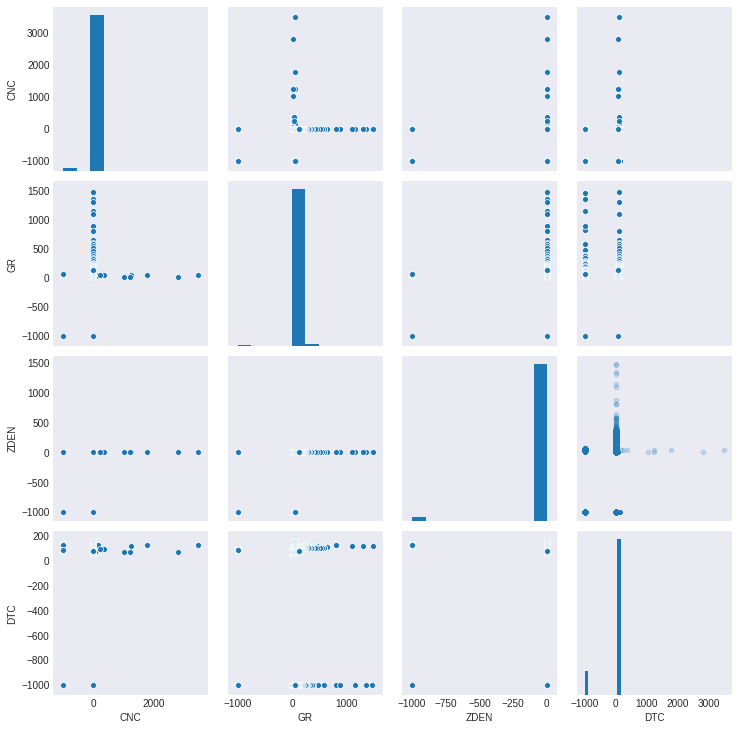

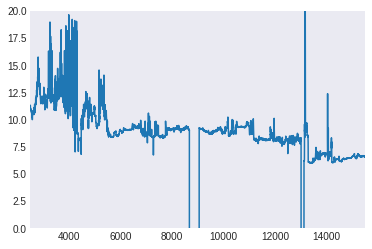

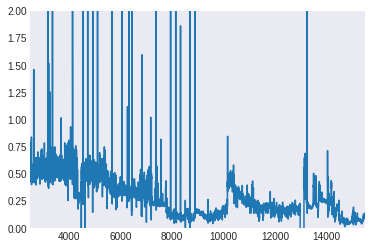

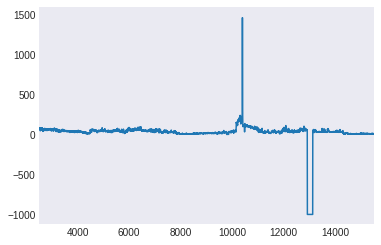

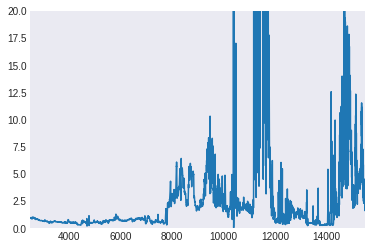

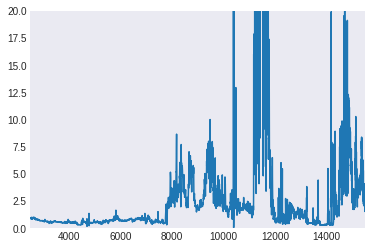

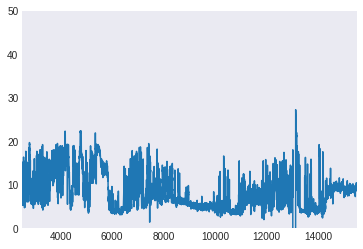

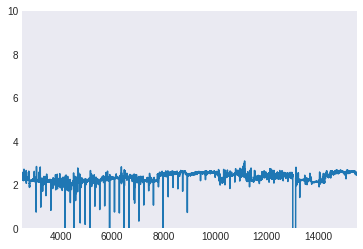

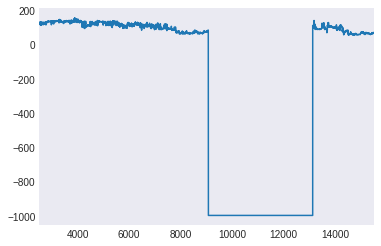

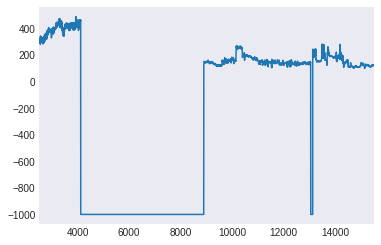

In [100]:
DROP_FEATURE = ['CAL','HRD','HRM','PE'] # DROP features
# DROP_FEATURE = ['CAL','HRD','HRM','PE']
REPLACE_ANOMALY = True

df1 = pd.read_csv('train.csv')
print(df1.isnull().sum(axis = 0))

print(df1.head())

# df1 = df1.iloc[20000:, :]
# df1.index = np.arange(0,len(df1.index))

start_well2 = 11000
start_well3 = 19939

x_start, x_end = 2500, 15500

plt.figure()
sb.pairplot(df1[['CNC', 'GR', 'ZDEN', 'DTC']])

plt.scatter(df1['CNC'], df1['GR'], s=20, alpha=0.2)

plt.figure()
plt.plot(df1['CAL'])
plt.ylim([0, 20])
plt.xlim([x_start, x_end])

plt.figure()
plt.plot(df1['CNC'])
plt.ylim([0, 2])
plt.xlim([x_start, x_end])

plt.figure()
plt.plot(df1['GR'])
# plt.ylim([0, 2])
plt.xlim([x_start, x_end])

plt.figure()
plt.plot(df1['HRD'])
plt.ylim([0, 20])
plt.xlim([x_start, x_end])

plt.figure()
plt.plot(df1['HRM'])
plt.ylim([0, 20])
plt.xlim([x_start, x_end])

plt.figure()
plt.plot(df1['PE'])
plt.ylim([0, 50])
plt.xlim([x_start, x_end])

plt.figure()
plt.plot(df1['ZDEN'])
plt.ylim([0, 10])
plt.xlim([x_start, x_end])

plt.figure()
plt.plot(df1['DTC'])
# plt.ylim([0, 10])
plt.xlim([x_start, x_end])

plt.figure()
plt.plot(df1['DTS'])
# plt.ylim([0, 10])
plt.xlim([x_start, x_end])

df1.drop(DROP_FEATURE, axis=1, inplace=True)
    
# print(df1['PE'][19939:].describe())
# df1['PE'][19939:] = df1['PE'][19939:] *100
# print(df1['PE'][19939:].describe())
# print(df1['PE'][:19939].describe())
# print(df1[df1.index == 19938].describe())
# print(df1.tail())

print(df1.head())
# plt.scatter(df1['DTC'], df1['DTS'], s=10, alpha=0.5)
# plt.axis((0,200,0,500))

## <a>4. Glimps Data</a>

<a>Top</a>

In [101]:
df1.describe()

,CNC,GR,ZDEN,DTC,DTS
count,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000
mean,-23.692615,38.959845,-20.229982,-54.891703,-9.737567
std,157.142679,108.504554,148.809506,372.858812,440.314119
min,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
25%,0.122800,17.248750,2.226700,66.304350,118.534350
50%,0.193600,36.821800,2.432200,78.355100,137.689300
75%,0.337150,58.346150,2.551350,107.022500,182.973150
max,3490.158200,1470.253400,3.259700,155.980300,487.438400


In [102]:
df1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30143 entries, 0 to 30142
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CNC     30143 non-null  float64
 1   GR      30143 non-null  float64
 2   ZDEN    30143 non-null  float64
 3   DTC     30143 non-null  float64
 4   DTS     30143 non-null  float64
dtypes: float64(5)
memory usage: 1.1 MB


## <a>5. Exploratory Data Analysis</a>

<a>Top</a>

Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, missing values, outliers, anomalies, patterns, or relationships within the data. 

In [103]:
# Replace all -999 with nan value
df1.replace(['-999', -999], np.nan, inplace=True)
print(df1.isnull().sum(axis = 0))
df1.describe()

CNC      735
GR       254
ZDEN     681
DTC     4054
DTS     4865
dtype: int64


,CNC,GR,ZDEN,DTC,DTS
count,29408.000000,29889.000000,29462.000000,26089.000000,25278.000000
mean,0.683437,47.780541,2.393818,91.814381,180.655730
std,30.689679,51.377519,0.196276,24.337910,81.141960
min,-0.102800,-0.146000,-1.923800,49.970500,80.580400
25%,0.127100,18.026100,2.234800,71.357000,129.446625
50%,0.198500,37.082200,2.439600,85.237600,144.593050
75%,0.343100,58.532800,2.553000,112.112600,191.475125
max,3490.158200,1470.253400,3.259700,155.980300,487.438400


In [104]:
matplotlib.rcParams['figure.figsize'] = (16.0, 9.0)

# Plot well logs
def log_plot(z, log, x_label='', y_label='Sample', title='', lineWidth=1):
    plt.plot(log, z, linewidth=lineWidth)
    plt.ylim(z.max(), z.min())
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.tick_params(labeltop=True, labelright=True)
    plt.grid(b=None, which='both', axis='y')
    
# Plot well logs
def log_plot2(z, log, x_label='Sample', y_label='', title='', lineWidth=1):
    plt.plot(z, log, linewidth=lineWidth)
    plt.xlim(z.min(), z.max())
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.tick_params(labeltop=True, labelright=True)
    plt.grid(b=None, which='both', axis='y')

In [105]:
# load test data from well 2
df2 = pd.read_csv('test.csv')

print(df2.isnull().sum(axis = 0), df2.shape)

# Remove missing 
for col in df2.columns.tolist():
    df2[col][df2[col]==-999] = np.nan

df2.dropna(axis=0, inplace=True)
df2.describe()

CAL     0
CNC     0
GR      0
HRD     0
HRM     0
PE      0
ZDEN    0
dtype: int64 (11088, 7)


,CAL,CNC,GR,HRD,HRM,PE,ZDEN
count,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000
mean,8.634049,0.158501,28.966414,4.028372,106.752210,7.353522,2.475884
std,0.044064,0.091298,43.648163,7.198112,2374.620246,1.239075,0.149440
min,8.500000,0.009800,0.852000,0.083900,0.102700,4.760800,2.033400
25%,8.625000,0.091700,8.449450,1.760775,1.865575,6.528075,2.378175
50%,8.625000,0.128300,18.168650,2.758900,3.176950,7.881700,2.533600
75%,8.671900,0.213500,36.470725,4.539675,5.034600,8.308325,2.581800
max,8.875000,0.559400,1124.442000,202.233000,62290.769500,13.840700,3.024800


In [106]:
df1_orig = df1.copy()

CNC      735
GR       254
ZDEN     681
DTC     4054
DTS     4865
dtype: int64
count    121.000000
mean       1.235612
std        0.768926
min       -1.923800
25%        0.978900
50%        1.353400
75%        1.712800
max        3.259700
Name: ZDEN, dtype: float64


/home/lei/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


CNC      735
GR       254
ZDEN     681
DTC     4054
DTS     4865
dtype: int64


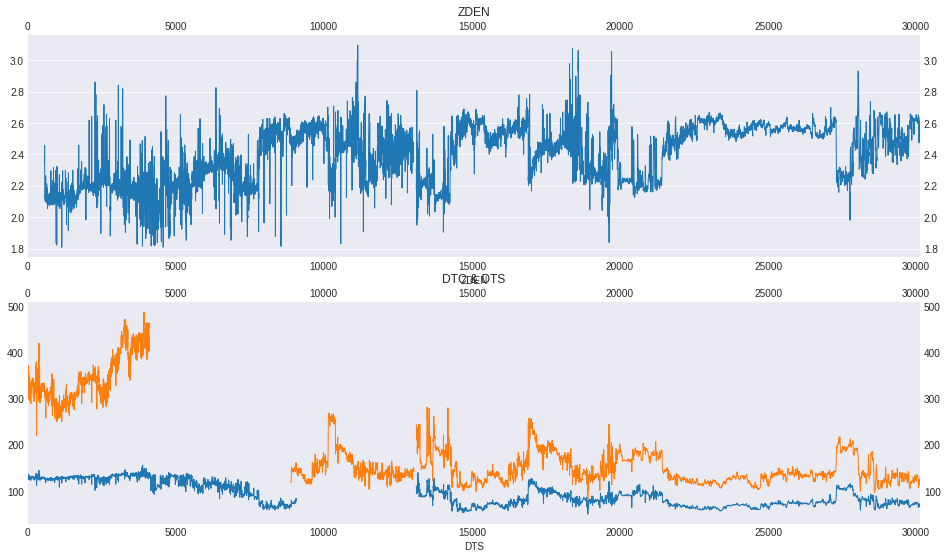

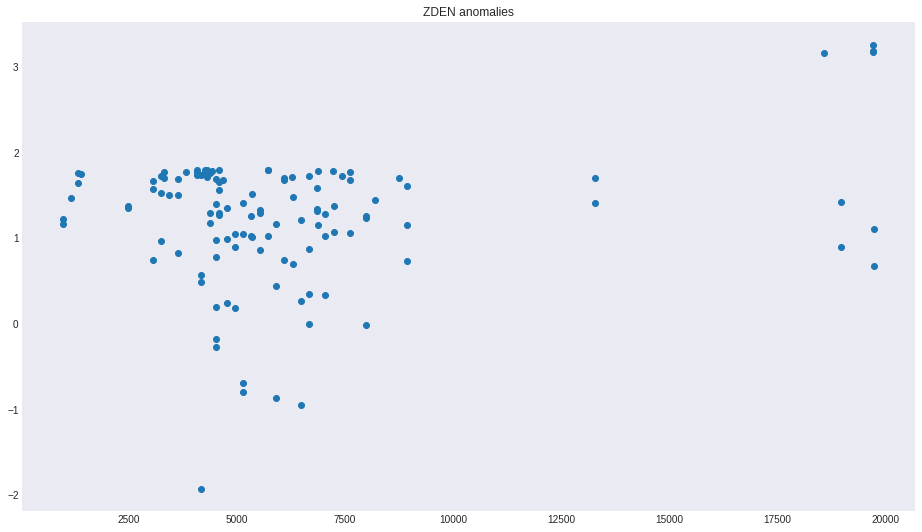

In [107]:
# Insert index as depth column
# df1.insert(0, 'DEP', df1.index) 

ilog = 2 # ['CAL', 'CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN', 'DTC', 'DTS']

# Plot 1 - before vs DTC/DTS, 2 - before vs after, 3 - after vs DTC/DTS 
compare = 3

logs = df1.columns.tolist()
item = logs[ilog]

anomaly = pd.DataFrame(columns=df1.columns)

# Interpolate values out of range
def interpolateValue(item, maxVal, minVal = float('-inf'), df=df1, df_orig=df1_orig):
    ind = ((df_orig[item] > maxVal) | (df_orig[item] < minVal))
    df.loc[ind,item] = np.nan
    
    # print(df[ind == True].index, df[ind][item])
    
    for i,x in enumerate(ind):
        if x:
            j = i + 1
            while ind[j]:
                j += 1
            df.iloc[i-1:j+1] = df.iloc[i-1:j+1].interpolate()
    
    # print(df[ind == True].index, df[ind][item])
    return df_orig.loc[ind, item]

print(df1.isnull().sum(axis = 0))

if item == 'CAL':
    pass
elif item == 'CNC':
    # print(df1[ind == True].index, df1[ind][item])
    anomaly = interpolateValue(item, 0.9)
    # print(df1[ind == True].index, df1[ind][item])
    # print(df1.isnull().sum(axis = 0))
elif item == 'GR':
    anomaly = interpolateValue(item, 400)
elif item == 'HRD':
    anomaly = interpolateValue(item, 250)
elif item == 'HRM':
    anomaly = interpolateValue(item, 500)
elif item == 'PE':
    anomaly = interpolateValue(item, 25)
elif item == 'ZDEN':
    anomaly = interpolateValue(item, 3.1, 1.8)
    
# Plot 1 - before vs DTC/DTS, 2 - before vs after, 3 - after vs DTC/DTS 
plt.subplots(nrows=2, ncols=2, figsize=(16,9))

plt.subplot(2, 1, 1)
if compare == 3:
#     log_plot2(df2.index+len(df1.index)-len(df2.index), df2[item])
    log_plot2(df1.index, df1[item], item, title=item)
else:
    plt.scatter(anomaly.index, anomaly,
                c='red', marker='o', s=20, alpha=0.5)
    log_plot2(df1_orig.index, df1_orig[item], item, title=item)

plt.subplot(2, 1, 2)
if compare == 2:
    log_plot2(df1.index, df1[item], item, title=item)
else:
    plt.subplot(2, 1, 2)
    log_plot2(df1.index, df1['DTC'], 'DTC')
    log_plot2(df1.index, df1['DTS'], 'DTS', title='DTC & DTS')

plt.figure()
plt.scatter(anomaly.index, anomaly, label="anomalies")
plt.title(item + " anomalies")

print(anomaly.describe())
print(df1.isnull().sum(axis = 0))

# plt.figure()
# plt.plot(df1['PE'][19938:19940])
# print(df1['PE'][19939:].describe())

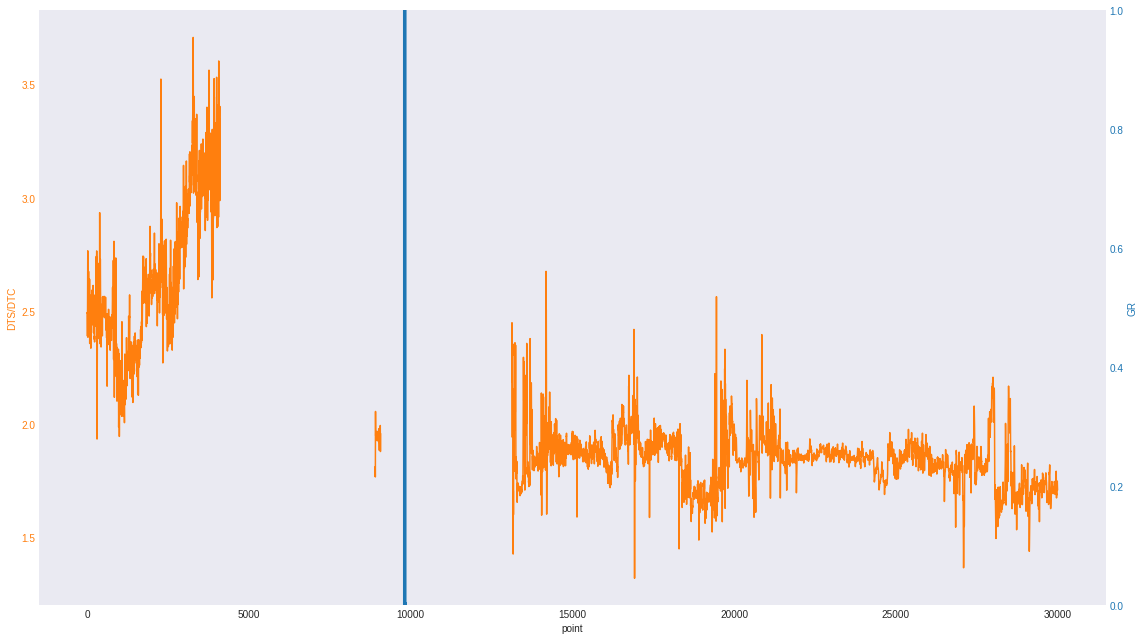

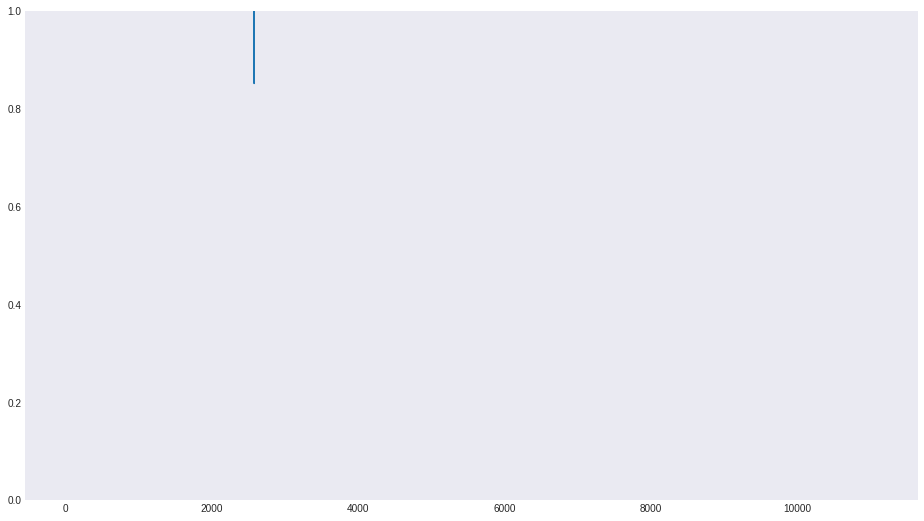

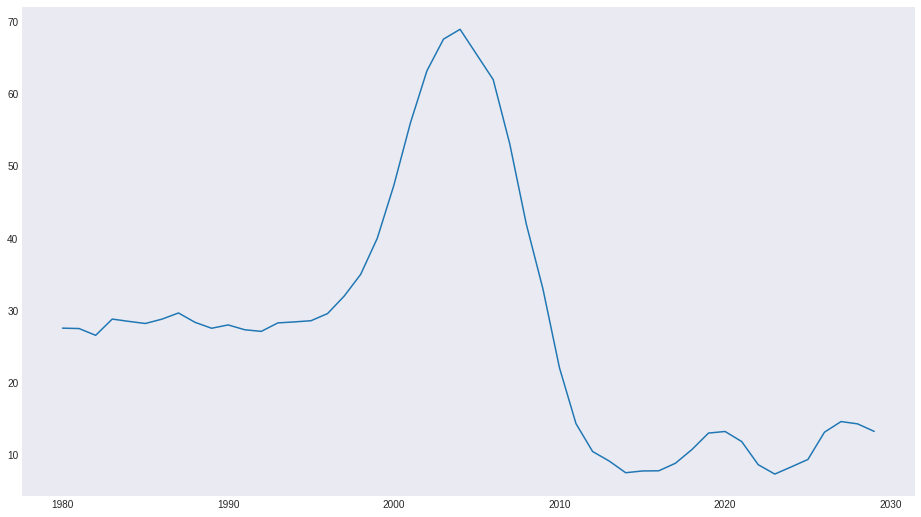

In [108]:
endPoint = 30000
i = 1
ymax = [0, 1, 0, 20, 20, 0, 0]

fig, ax1 = plt.subplots()

color = 'tab:orange'
ax1.set_xlabel('point')
ax1.set_ylabel('DTS/DTC', color=color)
ax1.plot(df1.index[:endPoint], df1['DTS'][:endPoint]/df1['DTC'][:endPoint], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(logs[i], color=color)  # we already handled the x-label with ax1
ax2.plot(df1.index[:endPoint], df1[logs[i]][:endPoint], color=color)
ax2.tick_params(axis='y', labelcolor=color)
if ymax[i]:
    ax2.set_ylim([0, ymax[i]])

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.figure()
plt.plot(df2[logs[i]][:endPoint])
if ymax[i]:
    plt.ylim([0, ymax[i]])

plt.figure()
plt.plot(df2[logs[i]][1980:2030])
    
# plt.figure()
# df3 = pd.read_csv('real_result_20perc.csv')
# plt.plot(df3['DTS'][:endPoint]/df3['DTC'][:endPoint])

(0, 11088)

<Figure size 1152x648 with 0 Axes>

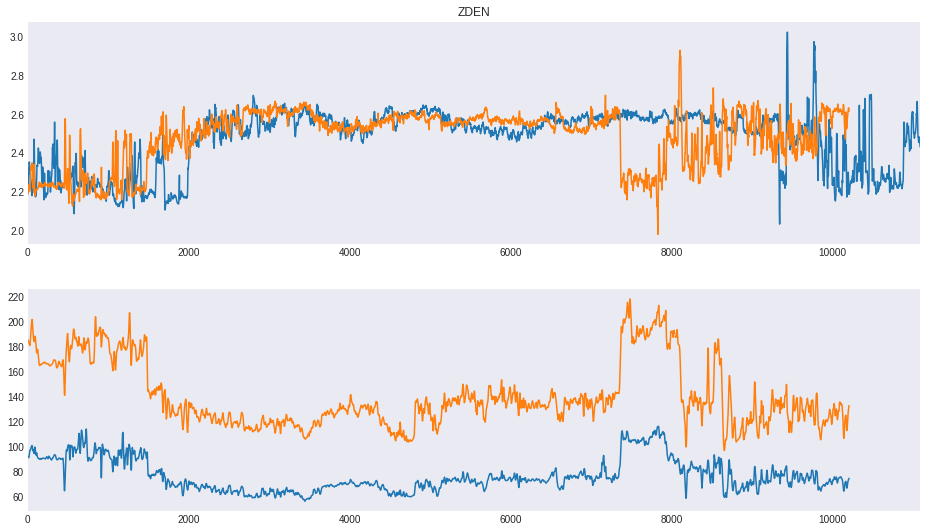

In [109]:
i = 2

plt.figure()
plt.subplots(nrows=2, ncols=2, figsize=(16,9))
plt.subplot(2, 1, 1)
plt.plot(df2[logs[i]])
plt.plot(df1_orig.index[19939:]-19939, df1_orig[logs[i]][19939:])
plt.title(logs[i])
plt.xlim([0, len(df2.index)])
# plt.ylim([0, 500])

plt.subplot(2, 1, 2)
plt.plot(df1_orig.index[19939:]-19939, df1_orig['DTC'][19939:])
plt.plot(df1_orig.index[19939:]-19939, df1_orig['DTS'][19939:])
plt.xlim([0, len(df2.index)])

In [110]:
if REPLACE_ANOMALY:
    print(df1.isnull().sum(axis = 0))
    print(df1.describe())

    for item in logs[:-2]:
        if item == 'CAL':
            pass
        elif item == 'CNC':
            anomaly = interpolateValue(item, 0.9)
        elif item == 'GR':
            anomaly = interpolateValue(item, 400)
        elif item == 'HRD':
            anomaly = interpolateValue(item, 25)
        elif item == 'HRM':
            anomaly = interpolateValue(item, 25)
        elif item == 'PE':
            anomaly = interpolateValue(item, 25)
        elif item == 'ZDEN':
            anomaly = interpolateValue(item, 3.1, 1.8)

    print(df1.isnull().sum(axis = 0))
    print(df1.describe())

CNC      735
GR       254
ZDEN     681
DTC     4054
DTS     4865
dtype: int64
                CNC            GR          ZDEN           DTC           DTS
count  29408.000000  29889.000000  29462.000000  26089.000000  25278.000000
mean       0.683437     47.780541      2.397328     91.814381    180.655730
std       30.689679     51.377519      0.176521     24.337910     81.141960
min       -0.102800     -0.146000      1.807900     49.970500     80.580400
25%        0.127100     18.026100      2.235100     71.357000    129.446625
50%        0.198500     37.082200      2.439600     85.237600    144.593050
75%        0.343100     58.532800      2.553000    112.112600    191.475125
max     3490.158200   1470.253400      3.096600    155.980300    487.438400
CNC      735
GR       254
ZDEN     681
DTC     4054
DTS     4865
dtype: int64
                CNC            GR          ZDEN           DTC           DTS
count  29408.000000  29889.000000  29462.000000  26089.000000  25278.000000
mean    

In [111]:
# for i, item in enumerate(logs[-2:]):
#     plt.scatter( df1.index, df1[item], s=2, label=item + ', # of nan = ' + str(df1[item].isna().sum()) )
# plt.legend()

In [112]:
# fig, ax1 = plt.subplots()

# color = 'tab:red'
# ax1.set_xlabel('point')
# ax1.set_ylabel('CAL', color=color)
# ax1.scatter(df1.index, df1['CAL'], color=color, s=2)
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('CNC', color=color)  # we already handled the x-label with ax1
# ax2.scatter(df1.index, df1['CNC'], color=color, s=2)
# ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped

(30143, 5)
(20688, 5)


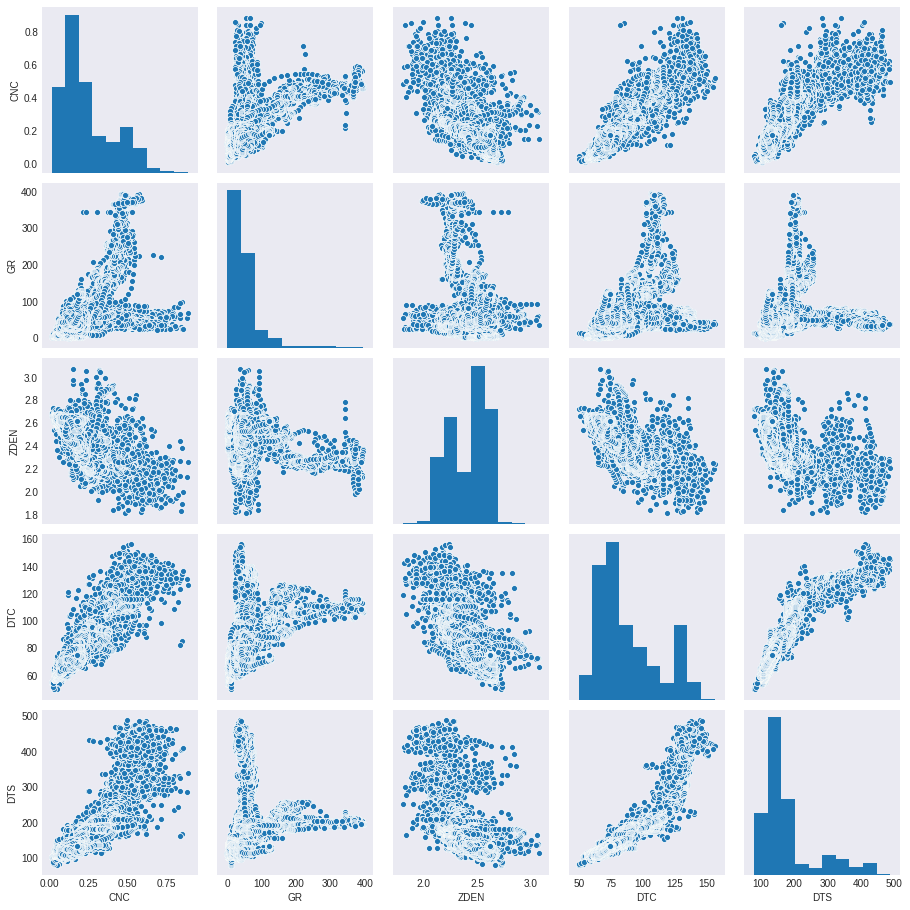

In [113]:
print(df1.shape)

# remove all rows that contains missing value
df1.dropna(axis=0, inplace=True)

print(df1.shape)

sb.pairplot(df1[['CNC', 'GR', 'ZDEN', 'DTC', 'DTS']])

method =  1 :  One-Class SVM
Number of anomalies =  25
(20663, 5)


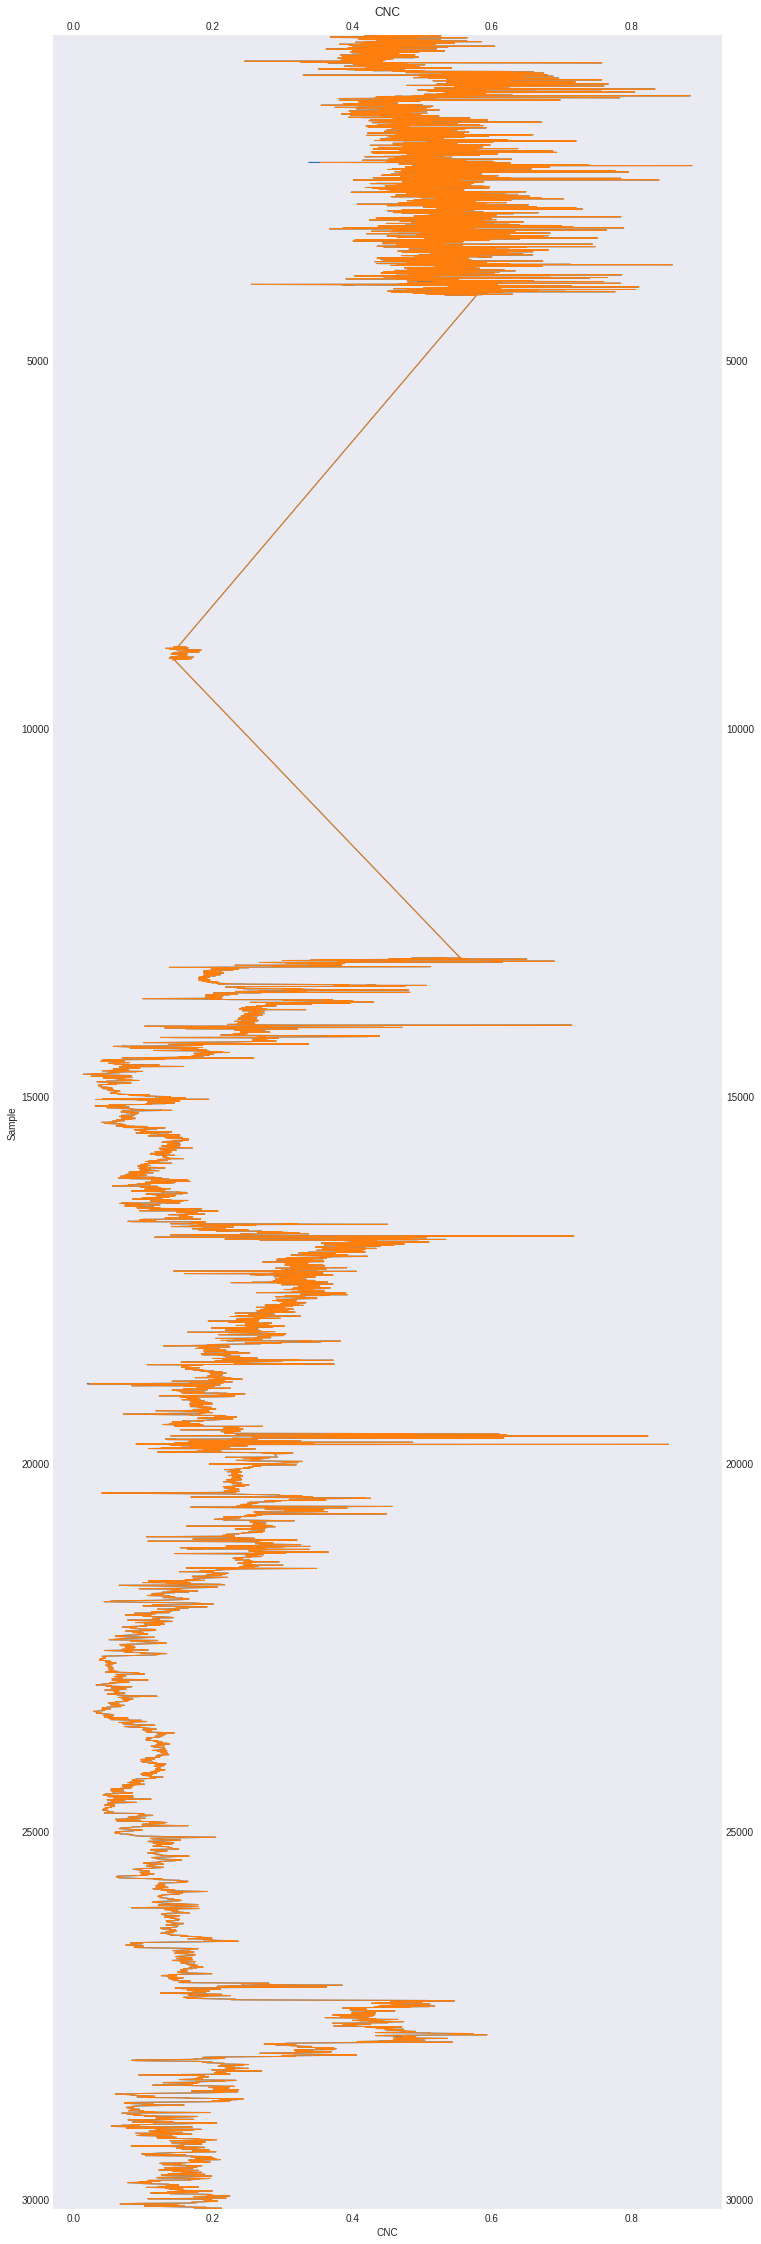

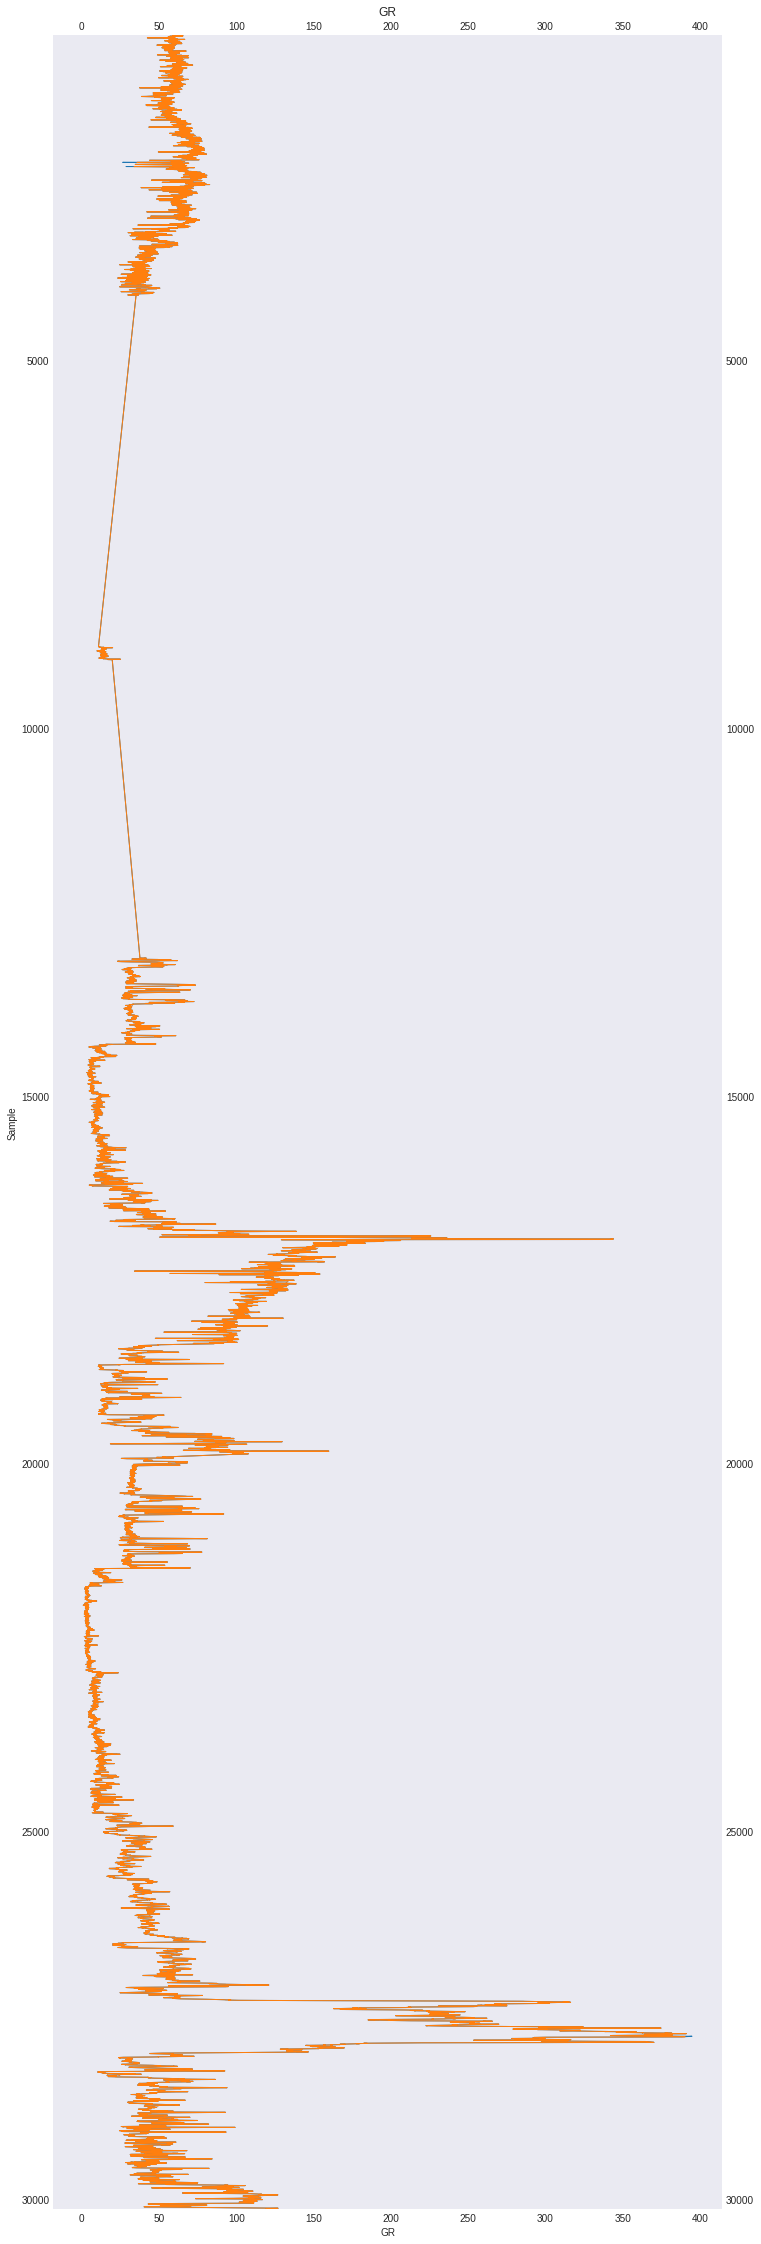

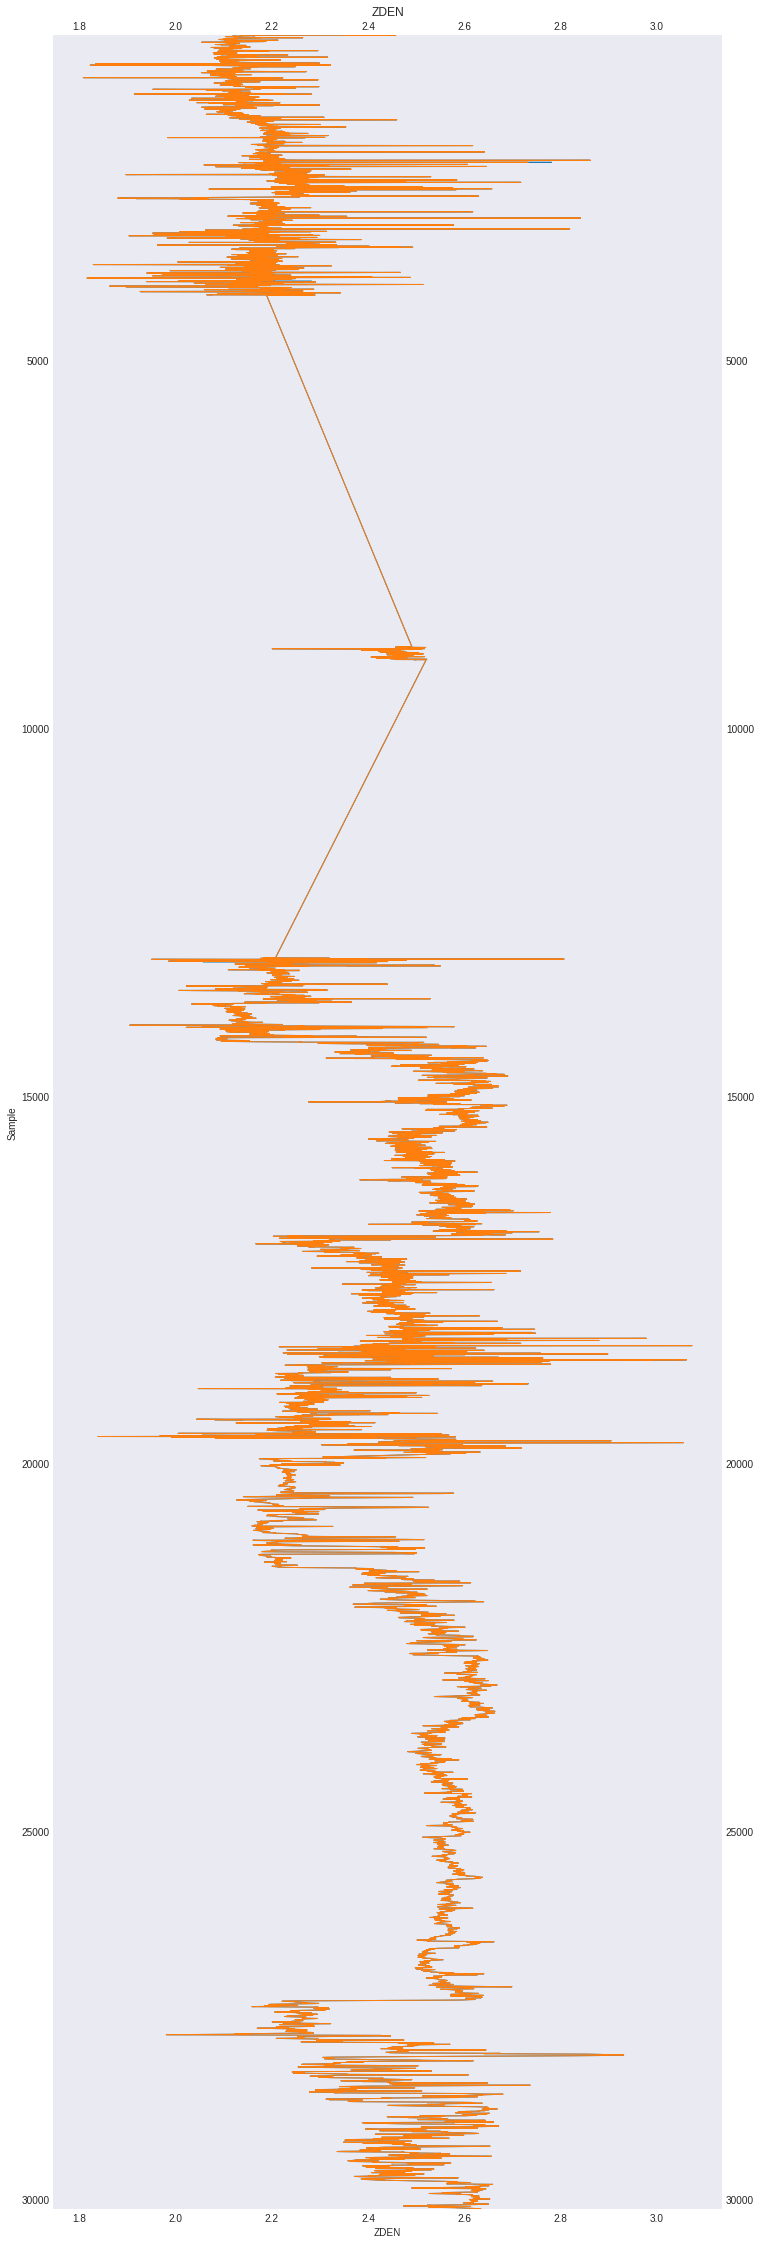

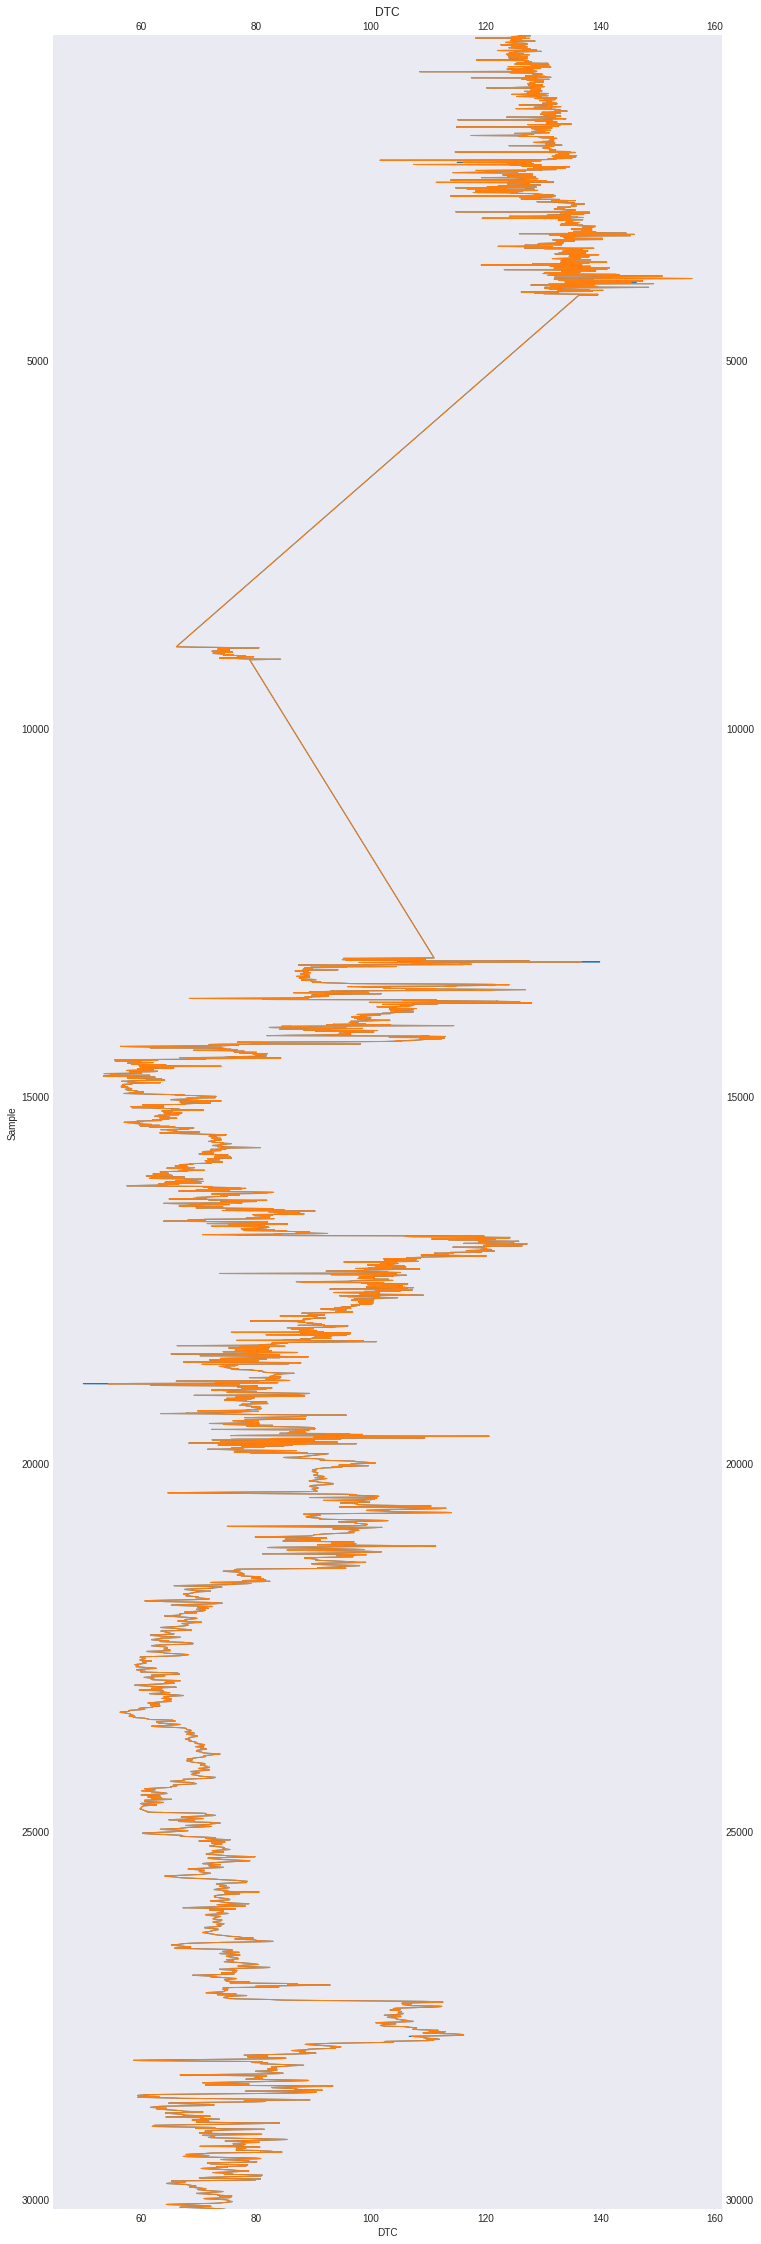

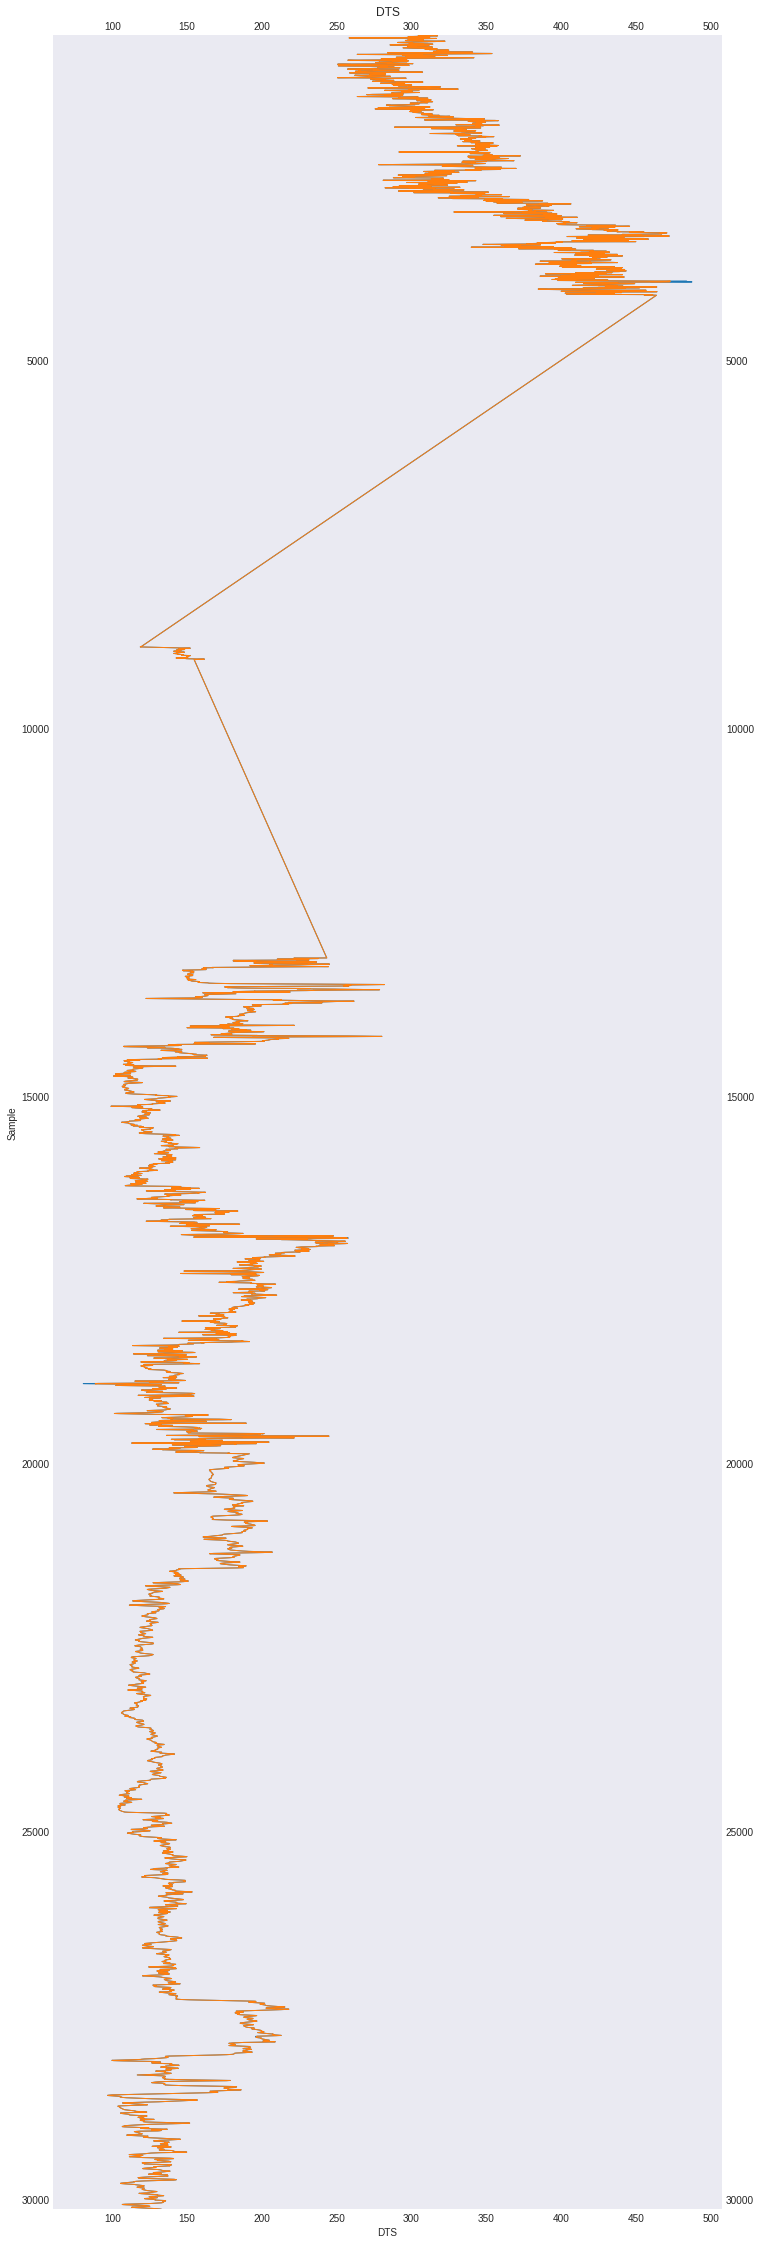

In [114]:
# Remove outliers
each_feature = False # remove anomalies for each feature
method = 1  # 1-OneClassSVM; 2-IsolationForest; 3-LocalOutlierFactor
outliers_fraction = 25 / 20525

# define outlier/anomaly detection methods to be compared
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma='scale')),
    ("Isolation Forest", IsolationForest(contamination=outliers_fraction, random_state=42, behaviour="new")),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction))] # 'auto'))]


# if method == 1:
#     # clf = svm.OneClassSVM(nu=outliers_fraction, gamma=0.1).fit(df1)
#     clf = svm.OneClassSVM(nu=outliers_fraction, gamma='scale').fit(df1[['CNC']])
#     normal = clf.fit_predict(df1[['CNC']])
# elif method == 2:
#     clf = IsolationForest(contamination=outliers_fraction, random_state=42, behaviour="new")
#     normal = clf.fit_predict(df1[['CNC']])
# elif method == 3:
#     clf = LocalOutlierFactor(n_neighbors=35, contamination='auto') #=outliers_fraction)
#     normal = clf.fit_predict(df1[['CNC']])

normal = np.zeros(df1.shape[0], )

print('method = ', method, ': ', anomaly_algorithms[method][0])

if each_feature:
    # detect anomaly for each features
    for i, item in enumerate(logs[:-2]):
        clf = anomaly_algorithms[method][1].fit_predict(df1[[item]])

        plt.figure(figsize=(12.0, 40.0))
        # log_plot(df1.index, df1[item])
        log_plot(df1.index[clf==1], df1[item][clf==1], item, title=item)
        # plt.xlim(0, 1.1)
        print(item, -sum(clf[clf==-1]))

        normal += clf
        
        print(normal.shape)
        
    # remove anamoly
    if method in [0, 1, 2, 3]:
        df1 = df1[normal==df1.shape[1]-2]
        print(df1.shape)
else:
    clf = anomaly_algorithms[method][1].fit_predict(df1)

    for i, item in enumerate(logs):
        plt.figure(figsize=(12.0, 40.0))
        log_plot(df1.index, df1[item])
        log_plot(df1.index[clf==1], df1[item][clf==1], item, title=item)

    print("Number of anomalies = ", -sum(clf[clf==-1]))

    # remove anamoly
    if method in [0, 1, 2, 3]:
        df1 = df1[clf==1]
        print(df1.shape)

In [115]:
# # Remove outlier by measuring z-score
# z_scores = stats.zscore(df1)
# abs_z_scores = np.abs(z_scores)
# filtered_entries = (abs_z_scores < 5).all(axis=1)
# new_df = df1[filtered_entries]

# new_df.info(verbose=True)

# for i, item in enumerate(logs[:-2]):
#     plt.figure()
#     plt.plot(df1.index, df1[item])
#     plt.plot(new_df.index, new_df[item])
#     plt.title( item + ', # of nan = ' + str(df1[item].isna().sum()) )

In [116]:
# # Remove DTC >=110
# if False:
#     print(df1.shape)

#     df1= df1[df1["DTC"] < 110]

#     print(df1.shape)

In [117]:
# df1.columns.tolist()

In [118]:
# print(df1['DTC'].shape)
# plt.scatter(df1.index, df1['DTC'], s=1)
# plt.title('DTC')

In [119]:
# plt.scatter(df1.index, df1['CNC'], s=1)

In [120]:
# plt.scatter(df1.index, df1['CAL'], s=1)
# # plt.title('CAL')

In [121]:
# # check if there's any co-linearity between features
# # you may check this for all of the features and see if there's any good finding. 
# plt.scatter(df1['CAL'], df1['DTC'], s=10, alpha=0.5)

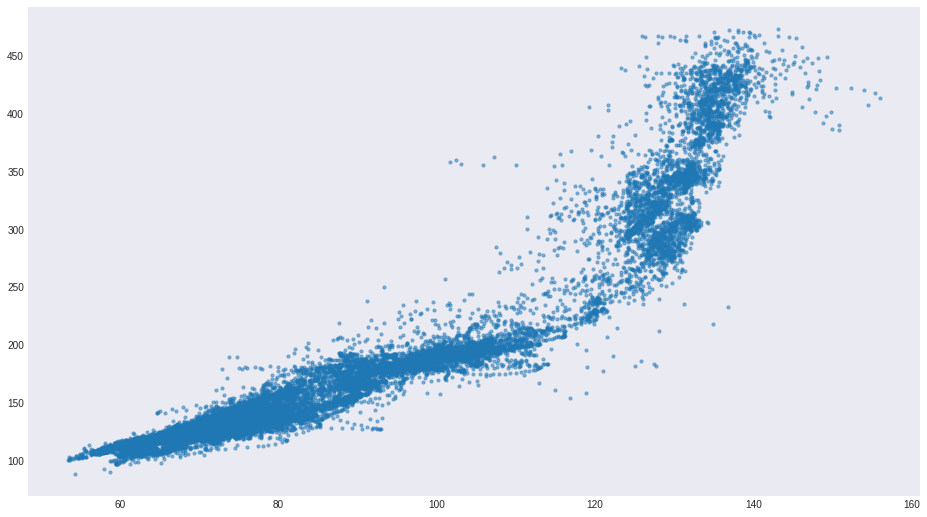

In [122]:
# check if there's any co-linearity between features
# you may check this for all of the features and see if there's any good finding. 
plt.scatter(df1['DTC'], df1['DTS'], s=10, alpha=0.5)

In [123]:
# # another library from Seaborn to check the co-linearity
# sb.pairplot(df1[['ZDEN', 'DTC']])
# # sb.pairplot(df1[['CAL', 'CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN', 'DTC', 'DTS']])

## <a>6. Build Machine Learning Models</a>

<a>Top</a>

In [124]:
def result_plot(y_predict, y_real):
    # check the accuracy of predicted data and plot the result
    print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_real, y_predict))))
    print('DTC:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_real[:, 0], y_predict[:, 0]))))
    print('DTS:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_real[:, 1], y_predict[:, 1]))))
    plt.subplots(nrows=2, ncols=2, figsize=(16,10))
    plt.subplot(2, 2, 1)
    plt.plot(y_real[:, 0])
    plt.plot(y_predict[:, 0])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTC')
    plt.title('DTC Prediction Comparison')

    plt.subplot(2, 2, 2)
    plt.plot(y_real[:, 1])
    plt.plot(y_predict[:, 1])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTS')
    plt.title('DTS Prediction Comparison')
    
    plt.subplot(2, 2, 3)
    plt.scatter(y_real[:, 0], y_predict[:, 0])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTC Prediction Comparison')
    
    plt.subplot(2, 2, 4)
    plt.scatter(y_real[:, 1], y_predict[:, 1])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTS Prediction Comparison')

    plt.show()
    
    return np.sqrt(mean_squared_error(y_real, y_predict))

In [125]:
# Train a binary classifier
print(df1.head())

# Insert label ROCK column
if 'ROCK' not in df1.columns:
    df1.insert(0, 'ROCK', 1)

df1.loc[:, 'ROCK'] = 1
df1.loc[df1.index > 5000, 'ROCK'] = 0 

# plt.subplots(nrows=2, ncols=1, figsize=(16,10))
# plt.subplot(2, 1, 1)
# plt.plot(df1['ROCK'])
# plt.subplot(2, 1, 2)
# plt.plot(df1['DTC'])

# print(len(df1.index))

# split into input (X) and output (y) variables
dataset = np.array(df1)
XData = dataset[:,1:-2]
YData = dataset[:,0]

X, x_test, y, y_test = train_test_split(XData, YData, stratify=YData, test_size=0.25)

# define the keras model
model_bc = keras.Sequential()
model_bc.add(layers.Dense(12, input_dim=len(df1.columns)-3, activation='relu'))
model_bc.add(layers.Dense(8, activation='relu'))
model_bc.add(layers.Dense(1, activation='sigmoid'))

# compile the keras model
model_bc.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000)

if True:
    history = model_bc.fit(
        XData, YData,
        batch_size=5000, epochs=400, 
        verbose=1,
        callbacks=[early_stop, tfdocs.modeling.EpochDots()],
        shuffle=True)
else:
    history = model_bc.fit(
        X, y,
        batch_size=5000, epochs=4000, 
        validation_data=(x_test, y_test), 
#         validation_split = 0.00002,
        verbose=1,
        callbacks=[early_stop, tfdocs.modeling.EpochDots()],
        shuffle=True)
    
    plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
    plotter.plot({'Basic': history}, metric = "accuracy")
    plt.ylabel('accuracy')
    plt.ylim([0,1])

        CNC       GR    ZDEN       DTC       DTS
573  0.5173  57.1903  2.3510  125.9611  306.8676
574  0.4966  63.1593  2.4055  125.9726  305.8347
575  0.4433  64.5217  2.4579  125.8528  305.9089
576  0.4309  63.0144  2.4219  125.7362  305.1737
577  0.4469  60.8421  2.3138  125.9774  304.4476
Train on 20663 samples
Epoch 1/400


/home/lei/anaconda3/envs/tf/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


 5000/20663 [======>.......................] - ETA: 0s - loss: 11.7065 - accuracy: 0.2062WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy

Epoch: 0, accuracy:0.2053,  loss:11.4993,  
20663/20663 [==============================] - 0s 16us/sample - loss: 11.4993 - accuracy: 0.2053
Epoch 2/400
20663/20663 [==============================] - 0s 1us/sample - loss: 9.8164 - accuracy: 0.2215
Epoch 3/400
20663/20663 [==============================] - 0s 1us/sample - loss: 8.1390 - accuracy: 0.2430
Epoch 4/400
20663/20663 [==============================] - 0s 1us/sample - loss: 6.4582 - accuracy: 0.2749
Epoch 5/400
20663/20663 [==============================] - 0s 1us/sample - loss: 4.7907 - accuracy: 0.3320
Epoch 6/400
20663/20663 [==============================] - 0s 1us/sample - loss: 3.0988 - accuracy: 0.4206
Epoch 7/400
20663/20663 [==============================] - 0s 1us/sample - loss: 1.3272 - accuracy: 0.6014

20663/20663 [==============================] - 0s 1us/sample - loss: 0.3938 - accuracy: 0.8291
Epoch 27/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.3924 - accuracy: 0.8291
Epoch 28/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.3909 - accuracy: 0.8291
Epoch 29/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.3894 - accuracy: 0.8291
Epoch 30/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.3879 - accuracy: 0.8291
Epoch 31/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.3864 - accuracy: 0.8291
Epoch 32/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.3849 - accuracy: 0.8291
Epoch 33/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.3834 - accuracy: 0.8291
Epoch 34/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.3819 - accuracy: 0.8291
Epoch 35/400
20663/20663 [===============

20663/20663 [==============================] - 0s 1us/sample - loss: 0.3554 - accuracy: 0.8291
Epoch 52/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.3538 - accuracy: 0.8291
Epoch 53/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.3523 - accuracy: 0.8291
Epoch 54/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.3506 - accuracy: 0.8291
Epoch 55/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.3491 - accuracy: 0.8291
Epoch 56/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.3476 - accuracy: 0.8291
Epoch 57/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.3460 - accuracy: 0.8291
Epoch 58/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.3445 - accuracy: 0.8291
Epoch 59/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.3428 - accuracy: 0.8291
Epoch 60/400
20663/20663 [===============

Epoch 77/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.3151 - accuracy: 0.8291
Epoch 78/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.3139 - accuracy: 0.8291
Epoch 79/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.3122 - accuracy: 0.8291
Epoch 80/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.3109 - accuracy: 0.8291
Epoch 81/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.3093 - accuracy: 0.8291
Epoch 82/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.3078 - accuracy: 0.8291
Epoch 83/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.3062 - accuracy: 0.8291
Epoch 84/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.3048 - accuracy: 0.8291
Epoch 85/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.3033 - accuracy: 0.8291
Epoch 86/400
20663/20663 [==

20663/20663 [==============================] - 0s 1us/sample - loss: 0.2791 - accuracy: 0.8291
Epoch 103/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.2778 - accuracy: 0.8291
Epoch 104/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.2767 - accuracy: 0.8291
Epoch 105/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.2752 - accuracy: 0.8291
Epoch 106/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.2738 - accuracy: 0.8291
Epoch 107/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.2724 - accuracy: 0.8291
Epoch 108/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.2710 - accuracy: 0.8292
Epoch 109/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.2696 - accuracy: 0.8292
Epoch 110/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.2685 - accuracy: 0.8292
Epoch 111/400
20663/20663 [======

20663/20663 [==============================] - 0s 1us/sample - loss: 0.2462 - accuracy: 0.8374
Epoch 128/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.2449 - accuracy: 0.8384
Epoch 129/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.2436 - accuracy: 0.8348
Epoch 130/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.2422 - accuracy: 0.8402
Epoch 131/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.2409 - accuracy: 0.8391
Epoch 132/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.2396 - accuracy: 0.8407
Epoch 133/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.2385 - accuracy: 0.8404
Epoch 134/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.2371 - accuracy: 0.8412
Epoch 135/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.2360 - accuracy: 0.8521
Epoch 136/400
20663/20663 [======

20663/20663 [==============================] - 0s 1us/sample - loss: 0.2150 - accuracy: 0.8917
Epoch 153/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.2139 - accuracy: 0.9134
Epoch 154/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.2127 - accuracy: 0.9031
Epoch 155/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.2115 - accuracy: 0.9125
Epoch 156/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.2103 - accuracy: 0.9158
Epoch 157/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.2092 - accuracy: 0.9017
Epoch 158/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.2079 - accuracy: 0.9223
Epoch 159/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.2068 - accuracy: 0.9241
Epoch 160/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.2056 - accuracy: 0.9309
Epoch 161/400
20663/20663 [======

20663/20663 [==============================] - 0s 1us/sample - loss: 0.1865 - accuracy: 0.9455
Epoch 178/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1852 - accuracy: 0.9555
Epoch 179/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1841 - accuracy: 0.9466
Epoch 180/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1831 - accuracy: 0.9578
Epoch 181/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1825 - accuracy: 0.9459
Epoch 182/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1812 - accuracy: 0.9593
Epoch 183/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1799 - accuracy: 0.9501
Epoch 184/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1784 - accuracy: 0.9562
Epoch 185/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1773 - accuracy: 0.9539
Epoch 186/400
20663/20663 [======

20663/20663 [==============================] - 0s 1us/sample - loss: 0.1592 - accuracy: 0.9656
Epoch 203/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1582 - accuracy: 0.9657
Epoch 204/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1572 - accuracy: 0.9657
Epoch 205/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1562 - accuracy: 0.9666
Epoch 206/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1552 - accuracy: 0.9662
Epoch 207/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1548 - accuracy: 0.9715
Epoch 208/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1533 - accuracy: 0.9668
Epoch 209/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1522 - accuracy: 0.9686
Epoch 210/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1512 - accuracy: 0.9696
Epoch 211/400
20663/20663 [======

20663/20663 [==============================] - 0s 1us/sample - loss: 0.1350 - accuracy: 0.9762
Epoch 228/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1344 - accuracy: 0.9737
Epoch 229/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1332 - accuracy: 0.9785
Epoch 230/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1325 - accuracy: 0.9762
Epoch 231/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1317 - accuracy: 0.9785
Epoch 232/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1305 - accuracy: 0.9780
Epoch 233/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1298 - accuracy: 0.9776
Epoch 234/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1289 - accuracy: 0.9790
Epoch 235/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1280 - accuracy: 0.9771
Epoch 236/400
20663/20663 [======

20663/20663 [==============================] - 0s 1us/sample - loss: 0.1139 - accuracy: 0.9827
Epoch 253/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1134 - accuracy: 0.9833
Epoch 254/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1132 - accuracy: 0.9823
Epoch 255/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1117 - accuracy: 0.9828
Epoch 256/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1113 - accuracy: 0.9822
Epoch 257/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1109 - accuracy: 0.9831
Epoch 258/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1096 - accuracy: 0.9833
Epoch 259/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1089 - accuracy: 0.9833
Epoch 260/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.1081 - accuracy: 0.9828
Epoch 261/400
20663/20663 [======

20663/20663 [==============================] - 0s 1us/sample - loss: 0.0967 - accuracy: 0.9845
Epoch 278/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0961 - accuracy: 0.9849
Epoch 279/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0955 - accuracy: 0.9855
Epoch 280/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0949 - accuracy: 0.9850
Epoch 281/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0943 - accuracy: 0.9850
Epoch 282/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0938 - accuracy: 0.9854
Epoch 283/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0932 - accuracy: 0.9851
Epoch 284/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0925 - accuracy: 0.9851
Epoch 285/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0919 - accuracy: 0.9854
Epoch 286/400
20663/20663 [======

20663/20663 [==============================] - 0s 1us/sample - loss: 0.0828 - accuracy: 0.9870
Epoch 303/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0825 - accuracy: 0.9869
Epoch 304/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0821 - accuracy: 0.9872
Epoch 305/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0814 - accuracy: 0.9873
Epoch 306/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0809 - accuracy: 0.9872
Epoch 307/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0806 - accuracy: 0.9872
Epoch 308/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0799 - accuracy: 0.9873
Epoch 309/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0796 - accuracy: 0.9877
Epoch 310/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0790 - accuracy: 0.9879
Epoch 311/400
20663/20663 [======

20663/20663 [==============================] - 0s 1us/sample - loss: 0.0722 - accuracy: 0.9881
Epoch 328/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0716 - accuracy: 0.9877
Epoch 329/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0719 - accuracy: 0.9881
Epoch 330/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0712 - accuracy: 0.9881
Epoch 331/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0702 - accuracy: 0.9887
Epoch 332/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0699 - accuracy: 0.9888
Epoch 333/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0694 - accuracy: 0.9883
Epoch 334/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0690 - accuracy: 0.9886
Epoch 335/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0687 - accuracy: 0.9884
Epoch 336/400
20663/20663 [======

20663/20663 [==============================] - 0s 1us/sample - loss: 0.0632 - accuracy: 0.9889
Epoch 353/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0629 - accuracy: 0.9890
Epoch 354/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0628 - accuracy: 0.9889
Epoch 355/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0624 - accuracy: 0.9890
Epoch 356/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0621 - accuracy: 0.9889
Epoch 357/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0619 - accuracy: 0.9890
Epoch 358/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0615 - accuracy: 0.9892
Epoch 359/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0612 - accuracy: 0.9891
Epoch 360/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0610 - accuracy: 0.9890
Epoch 361/400
20663/20663 [======

20663/20663 [==============================] - 0s 1us/sample - loss: 0.0569 - accuracy: 0.9892
Epoch 378/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0567 - accuracy: 0.9890
Epoch 379/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0568 - accuracy: 0.9889
Epoch 380/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0575 - accuracy: 0.9887
Epoch 381/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0565 - accuracy: 0.9885
Epoch 382/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0562 - accuracy: 0.9887
Epoch 383/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0559 - accuracy: 0.9894
Epoch 384/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0558 - accuracy: 0.9893
Epoch 385/400
20663/20663 [==============================] - 0s 1us/sample - loss: 0.0555 - accuracy: 0.9892
Epoch 386/400
20663/20663 [======

In [126]:
# convert an array of values into a dataset matrix with zero padding
def create_dataset(dataset, look_back=1, pad=True):
    if pad:
        # dataset_pad = np.pad(dataset, ((look_back, look_back), (0, 0)), mode='constant', constant_values=0)
        dataset_pad = np.pad(dataset, ((look_back, look_back), (0, 0)), mode='edge')
    else:
        dataset_pad = dataset
        
    dataX = []
    for i in range(len(dataset_pad)-2*look_back):
        a = dataset_pad[i:(i+2*look_back+1), :]
        dataX.append(a)
    return np.array(dataX)

# print(df1[df1.index == 19938].describe())
# print(df1.tail())

def moving_average(a, n=5) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [145]:
# LSTM
LEARN_RATE = 0.002
TEST_SIZE = 0.00001
EPOCHS = 120
BATCH_SIZE = 500 # None # 1024
PAD_SIZE = 4
TIME_STEPS = 2*PAD_SIZE+1
N_FEATURES = len(df1.columns) - 2

print('LEARN_RATE:', LEARN_RATE, 'TEST_SIZE:', TEST_SIZE, 
      'EPOCHS:', EPOCHS, 'BATCH_SIZE:', BATCH_SIZE, 
      'PAD_SIZE:', PAD_SIZE, 'N_FEATURES:', N_FEATURES)

# seperate the features and targets
df1_data = np.array(df1)
x_trainwell1 = df1_data[:,:-2]
y_trainwell1 = df1_data[:,-2:]

# standize the matrix for training data
scaler = StandardScaler()
x_trainwell1 = scaler.fit_transform(x_trainwell1)

# print(x_trainwell1[:5,:], x_trainwell1[-5:,:])

x_data = create_dataset(x_trainwell1, PAD_SIZE)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_trainwell1, test_size=TEST_SIZE, random_state=100)

if BATCH_SIZE is not None:
    STEPS_PER_EPOCH = len(x_train)//BATCH_SIZE
else: 
    STEPS_PER_EPOCH = 1
    
def build_model():
    model = keras.Sequential([
        layers.Bidirectional(layers.LSTM(64, return_sequences=False, 
#                                          dropout=0.2, 
#                                          recurrent_dropout=0.2,
                                         kernel_initializer=initializers.glorot_uniform(seed=1), 
                                         kernel_regularizer=regularizers.l2(0.0001)), 
                             input_shape=(TIME_STEPS, N_FEATURES)),
#         layers.Dropout(0.2, seed=1),
        layers.BatchNormalization(),
#         layers.Bidirectional(layers.LSTM(64, return_sequences=False,
# #                                          dropout=0.5, 
#                                          kernel_regularizer=regularizers.l2(0.0001))),
#         layers.BatchNormalization(),
#         layers.Dropout(0.5, seed=100),
        layers.Dense(64,  kernel_initializer=initializers.glorot_uniform(seed=2), 
                     kernel_regularizer=regularizers.l2(0.01), activation='elu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4, seed=100),
        layers.Dense(64,  kernel_initializer=initializers.glorot_uniform(seed=3), 
                     kernel_regularizer=regularizers.l2(0.01), activation='elu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4, seed=200),
        layers.Dense(2, kernel_initializer=initializers.glorot_uniform(seed=4))
    ])

    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        LEARN_RATE,
        decay_steps=STEPS_PER_EPOCH*400,
        decay_rate=1,
        staircase=False)
    
    # optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
    # optimizer = tf.keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
    # optimizer = tf.keras.optimizers.Adamax(lr_schedule, beta_1=0.9, beta_2=0.999)
    # optimizer = tf.keras.optimizers.RMSprop(0.001)
    optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_2=0.999, amsgrad=True)

    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mse'])
    return model


model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10000)

model.summary()
# print(normed_train_data[:10], )

# example_batch = normed_train_data[:10]
# example_result = model.predict(example_batch)
# example_result

weight = np.ones(len(x_train))
# for i in range(5000):
#     if y_train[i, 0] < 123 and y_train[i, 1] > 250:
#         weight[i] = 4.0

# weight[:5000] = 2.0
# weight[10287:] = 2.0
# weight[10287:12000] = 2.0
# weight[17000:] = 2.0
SAMPLE_WEIGHT = weight
# print(len(moving_average(moving_average(weight, 500), 500)), len(x_train))
# print(SAMPLE_WEIGHT, SAMPLE_WEIGHT[4998:5002])
# print(len(df1[df1.index < 19938]))

np.random.seed(0)

history = model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE, epochs=EPOCHS, 
#     validation_data=(x_test, y_test), 
    validation_split = 0.00001,
    verbose=1,
    sample_weight=SAMPLE_WEIGHT,
    callbacks=[early_stop, tfdocs.modeling.EpochDots()],
    shuffle=True)

LEARN_RATE: 0.002 TEST_SIZE: 1e-05 EPOCHS: 110 BATCH_SIZE: 500 PAD_SIZE: 4 N_FEATURES: 4
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_18 (Bidirectio (None, 128)               35328     
_________________________________________________________________
batch_normalization_54 (Batc (None, 128)               512       
_________________________________________________________________
dense_60 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_55 (Batc (None, 64)                256       
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 64)                4160      
______________________________

20661/20661 [==============================] - 0s 20us/sample - loss: 438.1550 - mse: 436.5934 - val_loss: 6.4329 - val_mse: 4.8716
Epoch 44/110
20661/20661 [==============================] - 0s 20us/sample - loss: 440.8386 - mse: 439.2753 - val_loss: 3.5048 - val_mse: 1.9417
Epoch 45/110
20661/20661 [==============================] - 0s 20us/sample - loss: 433.3853 - mse: 431.8228 - val_loss: 3.6060 - val_mse: 2.0445
Epoch 46/110
20661/20661 [==============================] - 0s 20us/sample - loss: 441.5309 - mse: 439.9695 - val_loss: 12.9193 - val_mse: 11.3580
Epoch 47/110
20661/20661 [==============================] - 0s 20us/sample - loss: 452.4981 - mse: 450.9366 - val_loss: 3.8795 - val_mse: 2.3180
Epoch 48/110
20661/20661 [==============================] - 0s 19us/sample - loss: 450.1562 - mse: 448.5940 - val_loss: 16.8732 - val_mse: 15.3089
Epoch 49/110
20661/20661 [==============================] - 0s 20us/sample - loss: 434.7706 - mse: 433.2084 - val_loss: 6.1328 - val_mse: 4

20661/20661 [==============================] - 0s 20us/sample - loss: 396.7163 - mse: 395.1340 - val_loss: 5.5301 - val_mse: 3.9477
Epoch 100/110
20661/20661 [==============================] - 0s 19us/sample - loss: 400.9623 - mse: 399.3802 - val_loss: 5.4580 - val_mse: 3.8774
Epoch 101/110
18500/20661 [=========================>....] - ETA: 0s - loss: 400.2160 - mse: 398.6344
Epoch: 100, loss:399.6862,  mse:398.1048,  val_loss:2.6258,  val_mse:1.0464,  
20661/20661 [==============================] - 0s 20us/sample - loss: 399.6862 - mse: 398.1048 - val_loss: 2.6258 - val_mse: 1.0464
Epoch 102/110
20661/20661 [==============================] - 0s 20us/sample - loss: 396.2217 - mse: 394.6411 - val_loss: 15.5989 - val_mse: 14.0186
Epoch 103/110
20661/20661 [==============================] - 0s 20us/sample - loss: 412.9167 - mse: 411.3358 - val_loss: 3.0025 - val_mse: 1.4217
Epoch 104/110
20661/20661 [==============================] - 0s 20us/sample - loss: 399.9158 - mse: 398.3352 - val_

Root Mean Square Error is: 9.56628
DTC: 4.53792
DTS: 12.74499


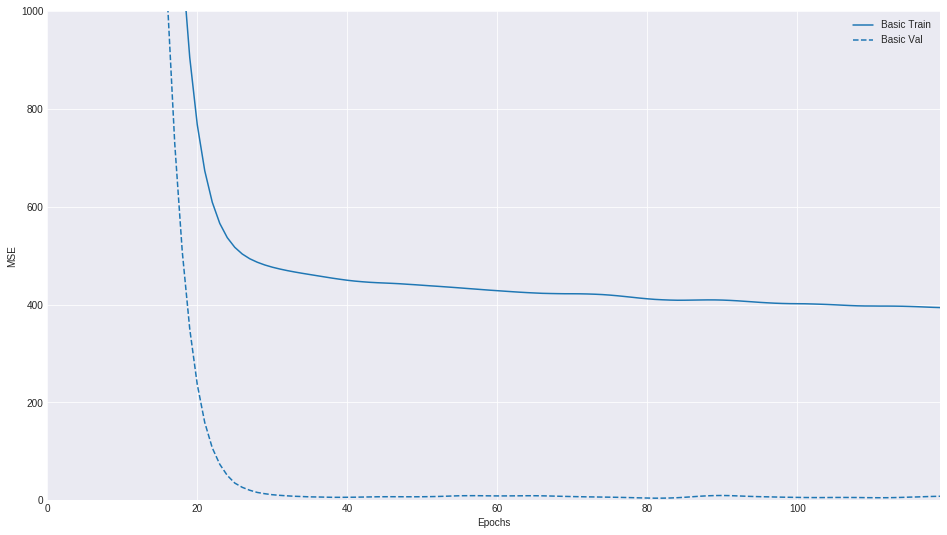

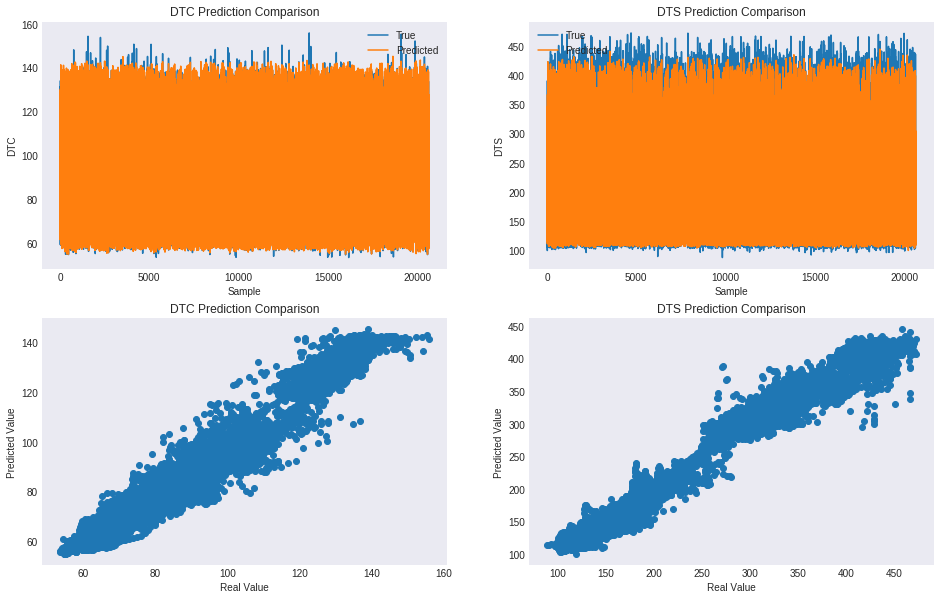

Root Mean Square Error is: 9.56606
DTC: 4.53784
DTS: 12.74468


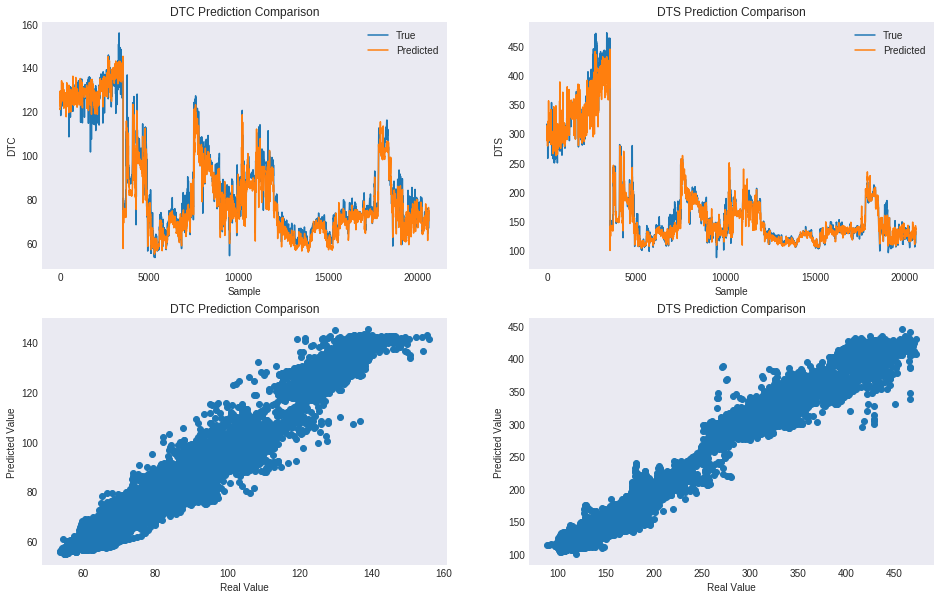

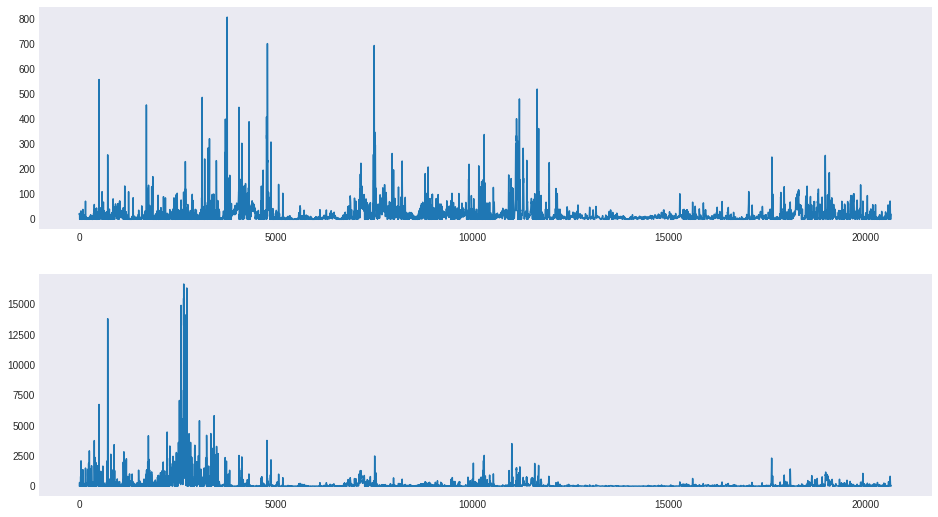

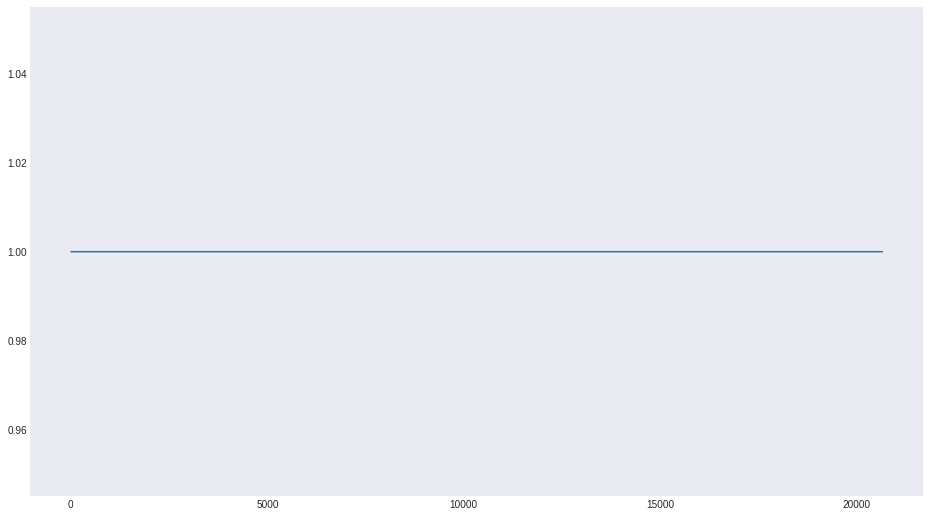

In [139]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mse")
plt.ylabel('MSE')
plt.ylim([0,1000])

# check the result on train dataset only
train_predictions = model.predict(x_train)
result_plot(np.array(train_predictions), np.array(y_train))

# # check the result on test dataset only 
# result_plot(model.predict(x_test), y_test)

# check the result on all dataset
y_predict_all = model.predict(x_data)
result_plot(y_predict_all, y_trainwell1)

# square errors 
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(np.square(np.subtract(y_predict_all[:, 0], y_trainwell1[:, 0]))) 

plt.subplot(2, 1, 2)
plt.plot(np.square(np.subtract(y_predict_all[:, 1], y_trainwell1[:, 1]))) 

plt.figure()
# weight = moving_average(y_train[:, 1], 500)
plt.plot(weight)
# plt.plot(moving_average(moving_average(SAMPLE_WEIGHT, 500), 500))

## <a>7. Prediction</a>

<a>Top</a>

0.13 604.0
3
2217 2217
Root Mean Square Error is: 14.72948
DTC: 6.25315
DTS: 19.86991


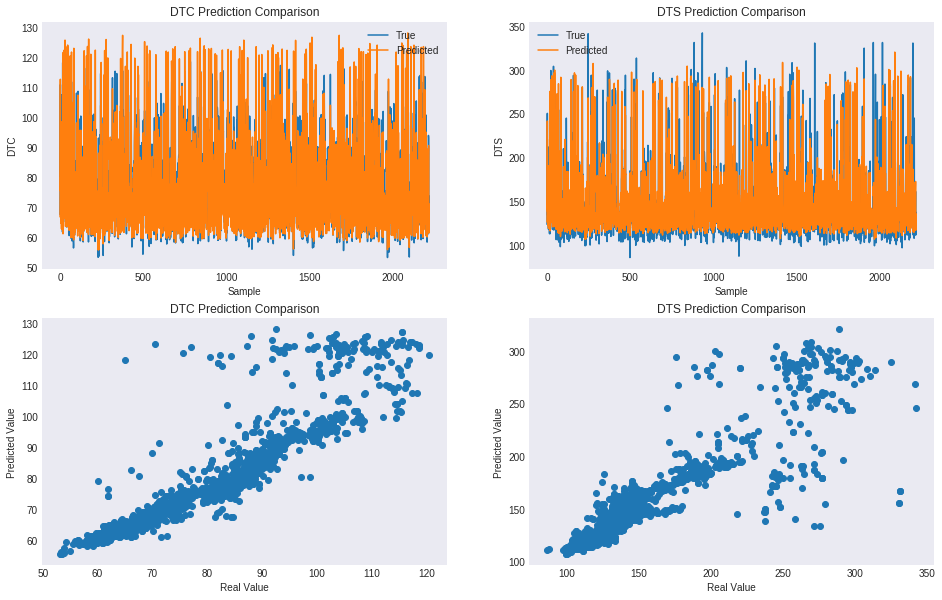

<class 'numpy.float64'>


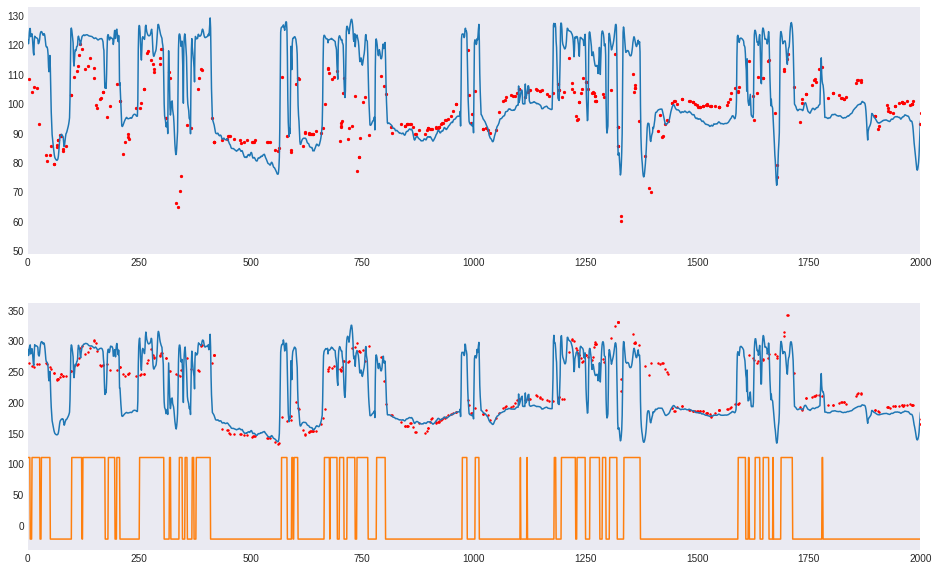

<Figure size 1152x648 with 0 Axes>

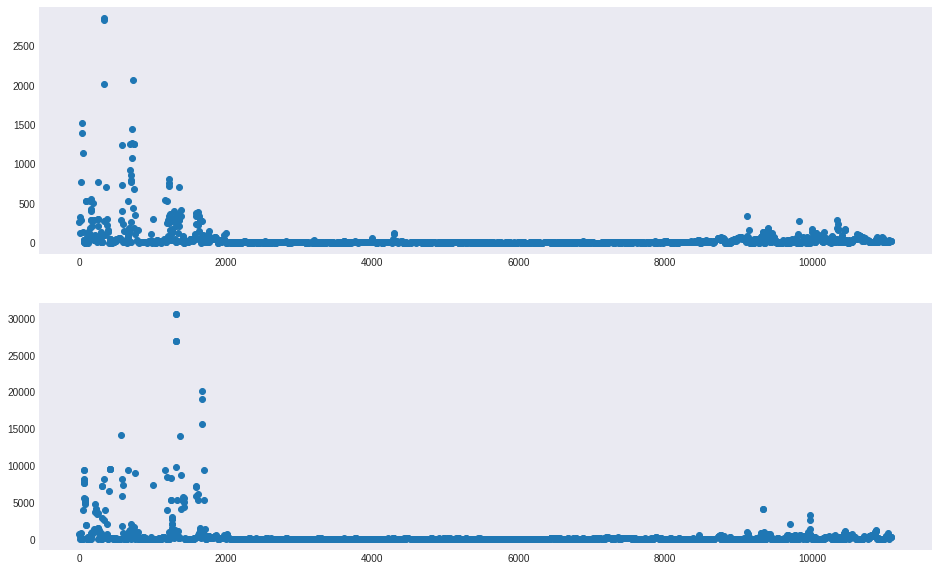

In [146]:
# load test data from well 2
df2 = pd.read_csv('test.csv')

# DELETE features
df2.drop(DROP_FEATURE, axis=1, inplace=True)

# Remove missing 
for col in df2.columns.tolist():
    df2[col][df2[col]==-999] = np.nan

df2.dropna(axis=0, inplace=True)
df2_copy = df2.copy()

if REPLACE_ANOMALY:
    for item in logs[:-2]:
        if item == 'CAL':
            pass
        elif item == 'CNC':
            interpolateValue(item, 0.9, df=df2, df_orig=df2_copy)
        elif item == 'GR':
            anomaly = interpolateValue(item, 400, df=df2, df_orig=df2_copy)
        elif item == 'HRD':
            anomaly = interpolateValue(item, 25, df=df2, df_orig=df2_copy)
        elif item == 'HRM':
            anomaly = interpolateValue(item, 25, df=df2, df_orig=df2_copy)
        elif item == 'PE':
            anomaly = interpolateValue(item, 25, df=df2, df_orig=df2_copy)
        elif item == 'ZDEN':
            anomaly = interpolateValue(item, 3.1, 1.8, df=df2, df_orig=df2_copy)

df2_data = np.array(df2)

# predict rock type
predict_rock = model_bc.predict(df2_data)

shreshold = 0.13
predict_rock2 = predict_rock.copy()
predict_rock2[predict_rock > shreshold] = 1
predict_rock2[predict_rock <= shreshold] = 0
print(shreshold, np.sum(predict_rock2))

# predict_rock2[0:1991] = shreshold *2
# predict_rock2[1991:] = .0

df2_data_bc = np.column_stack((predict_rock2, df2_data)) 
df2_data_bc = scaler.transform(df2_data_bc)
x_trainwell2 = create_dataset(df2_data_bc, PAD_SIZE)

# print(x_trainwell2[:5, :], x_trainwell2[-5:, :])

y_trainwell2_predict = model.predict(x_trainwell2)

# load benchmark test data from well 2
df3 = pd.read_csv('real_result_20perc.csv')

# DELETE features
df3.drop(DROP_FEATURE, axis=1, inplace=True)

index = []
print(len(df2.columns))

# Insert index as depth column
df2_sorted = df2_copy
df2_sorted['IND'] = df2_sorted.index

df2_sorted = df2_copy.sort_values(by=[df2_copy.columns[1]])

def binarySearch(target, v):
    beg, end = 0, len(v)-1
    # print(beg, end)
    
    while beg + 1 < end:
        mid = beg + (end - beg) // 2
        
        # print(target, v[mid])
        if v[mid] < target:
            beg = mid
        else:
            end = mid
    
    #  print(target, v[beg], v[end], beg, end)
    if v[beg] == target:
        return beg
    if v[end] == target:
        return end
    return -999

for i, row in df3.iterrows():
    
    row = row.round(4)
    start = binarySearch(row[1].round(4), df2_sorted[df2_copy.columns[1]].round(4).tolist())
    # print('    ', i, start, df2_sorted.iloc[start, 1], row[1])
   
    while df2_sorted.iloc[start, 1].round(4) == row[1]:
        for k in range(len(df2_sorted.columns)-1):
            if row[k] != df2_sorted.iloc[start, k].round(4):
                break
            if k == len(df2_sorted.columns) - 2:
                # print(df2_sorted.iloc[start,-1])
                index.append(df2_sorted.iloc[start,-1])
        start += 1

# print(df3.iloc[0, :])
# print(df2.iloc[index[0], :])
print(len(df3.index), len(index))
if len(df3.index) != len(index):
    raise NameError('index length is wrong!')
    
# check the result
RMSE = result_plot(y_trainwell2_predict[index, :], np.array(df3.iloc[:,-2:]))
print(type(RMSE))

#prediction Plot

y_df3 = np.array(df3.iloc[:,-2:])

plt.subplots(nrows=2, ncols=1, figsize=(16,10))
plt.subplot(2, 1, 1)
plt.plot(y_trainwell2_predict[:,0])

real_data = np.stack((index, y_df3[:, -2]), axis = 1)
real_data_sort = real_data[np.argsort(real_data[:, 0])]
plt.scatter(index, y_df3[:, 0], color='red', s=5)
# plt.plot(real_data_sort[:, 0], real_data_sort[:, 1], color='m')
plt.xlim([0, 2000])

plt.subplot(2, 1, 2)
plt.plot(y_trainwell2_predict[:,1])

real_data = np.stack((index, y_df3[:, -1]), axis = 1)
real_data_sort = real_data[np.argsort(real_data[:, 0])]
plt.scatter(index, y_df3[:, 1], color='red', s=2)
plt.plot(df2_data_bc[:,0]*50)
# plt.plot(real_data_sort[:, 0], real_data_sort[:, 1], color='m')
plt.xlim([0, 2000])

# square errors 
plt.figure()
plt.subplots(nrows=2, ncols=1, figsize=(16,10))
plt.subplot(2, 1, 1)
plt.scatter(index, np.square(np.subtract(y_df3[:, 0], y_trainwell2_predict[index,0]))) 
# plt.xlim([0, 2000])

plt.subplot(2, 1, 2)
plt.scatter(index, np.square(np.subtract(y_df3[:, 1], y_trainwell2_predict[index,1])))
# plt.xlim([0, 2000])

date_time = datetime.now().strftime("%Y%m%d_%H_%M_%S")
rms = np.array2string(RMSE, precision=4)

output_result = pd.DataFrame({'DTC':y_trainwell2_predict[:,0], 'DTS':y_trainwell2_predict[:,1]})
output_result.head()
output_result.to_csv(path_or_buf='./result/'+rms+'-'+'_submission_'+date_time+'.csv', index=False)

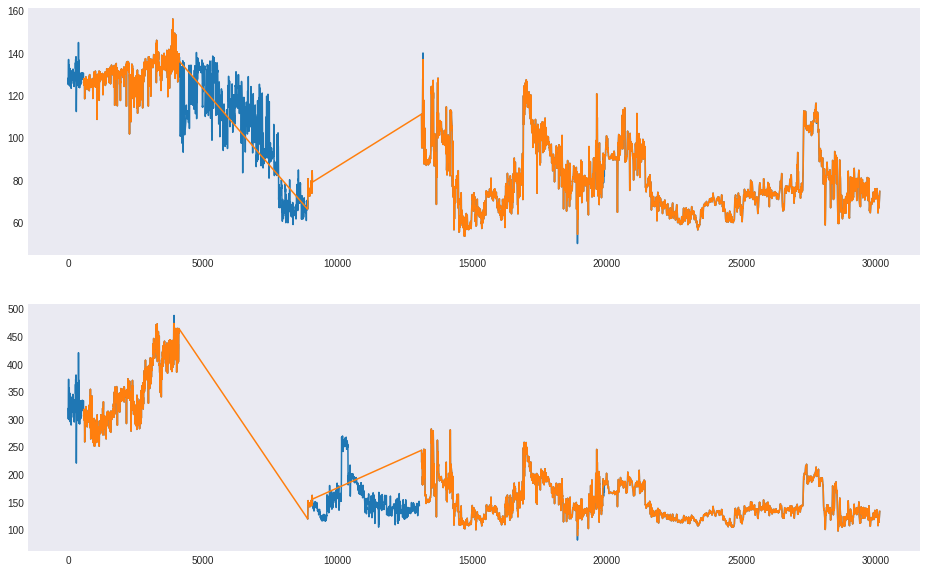

In [130]:
plt.subplots(nrows=2, ncols=1, figsize=(16,10))
plt.subplot(2, 1, 1)
plt.plot(df1_orig['DTC'])
plt.plot(df1.index, df1['DTC'])

plt.subplot(2, 1, 2)
plt.plot(df1_orig['DTS'])
plt.plot(df1.index, df1['DTS'])

(80, 500)

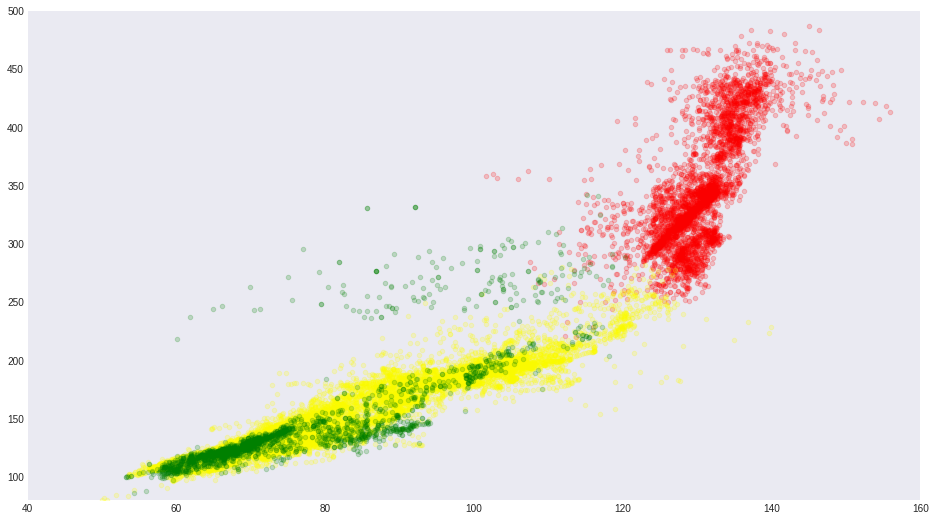

In [131]:
# check if there's any co-linearity between features
plt.scatter(df1_orig['DTC'][:5000], df1_orig['DTS'][:5000], s=20, c='red', alpha=0.2)
plt.scatter(df1_orig['DTC'][5000:], df1_orig['DTS'][5000:], s=20, c='yellow', alpha=0.2)
plt.scatter(df3['DTC'][:], df3['DTS'][:], s=20, c='green', alpha=0.2)
plt.xlim([40, 160])
plt.ylim([80, 500])

(0, 400)

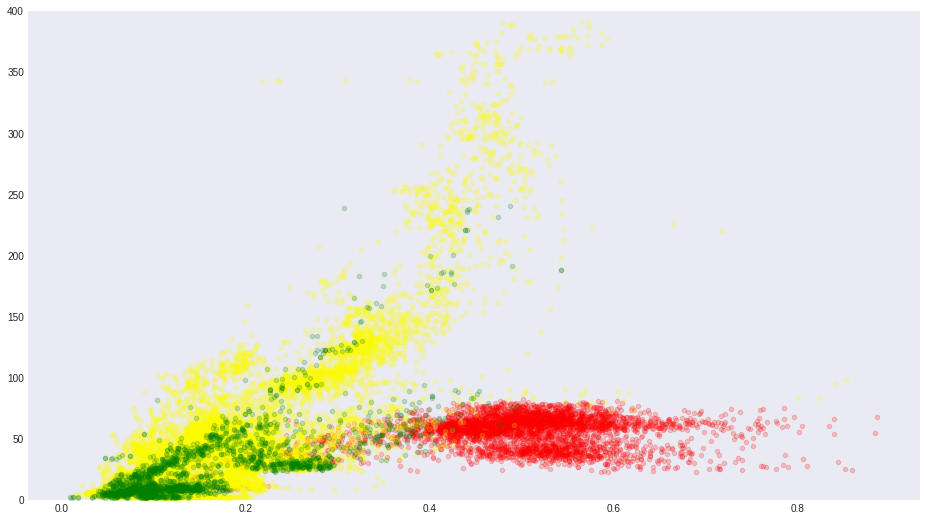

In [132]:
plt.scatter(df1['CNC'][:5000], df1['GR'][:5000], s=20, c='red', alpha=0.2)
plt.scatter(df1['CNC'][5000:], df1['GR'][5000:], s=20, c='yellow', alpha=0.2)
plt.scatter(df3['CNC'], df3['GR'], s=20, c='green', alpha=0.2)
plt.ylim([0, 400])

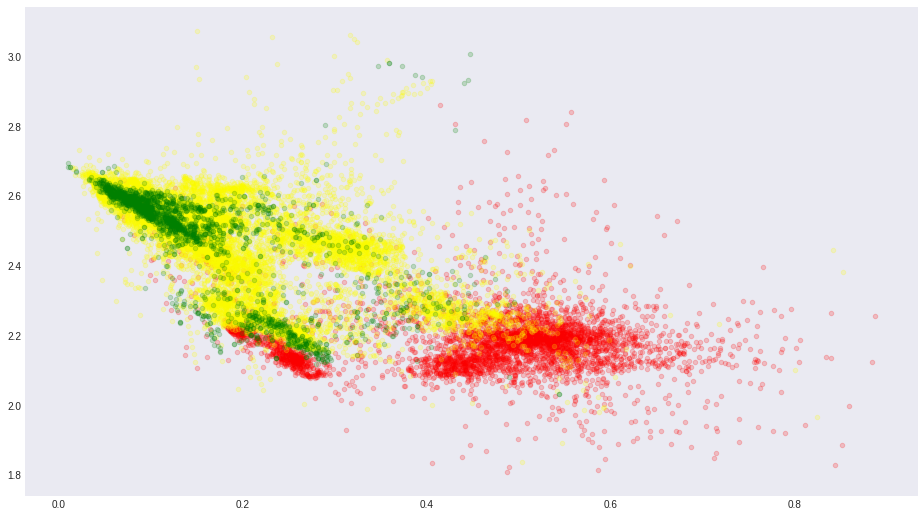

In [133]:
plt.scatter(df1['CNC'][:5000], df1['ZDEN'][:5000], s=20, c='red', alpha=0.2)
plt.scatter(df1['CNC'][5000:], df1['ZDEN'][5000:], s=20, c='yellow', alpha=0.2)
plt.scatter(df3['CNC'], df3['ZDEN'], s=20, c='green', alpha=0.2)
# plt.ylim([0, 500])

(0, 400)

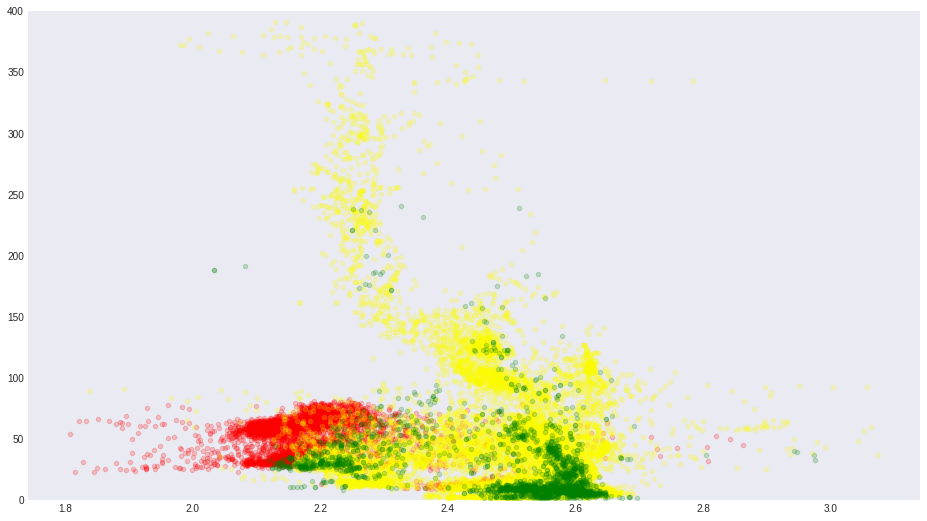

In [134]:
plt.scatter(df1['ZDEN'][:5000], df1['GR'][:5000], s=20, c='red', alpha=0.2)
plt.scatter(df1['ZDEN'][5000:], df1['GR'][5000:], s=20, c='yellow', alpha=0.2)
plt.scatter(df3['ZDEN'], df3['GR'], s=20, c='green', alpha=0.2)
plt.ylim([0, 400])

NameError: name 'well2_predict' is not defined

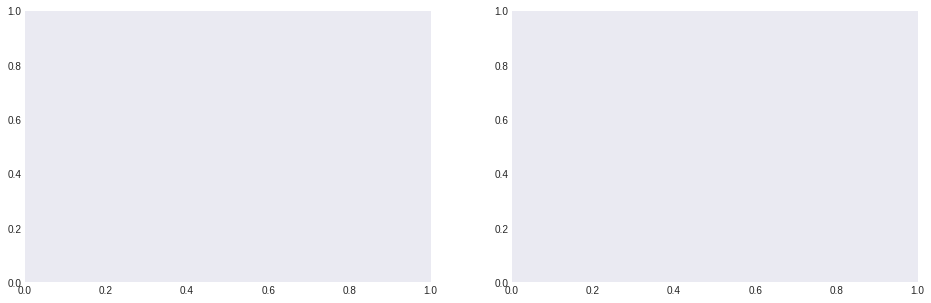

In [135]:
# plot the prediction results 
plt.subplots(nrows=1, ncols=2, figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(well2_predict[:, 0])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTC')
plt.title('DTC Prediction Comparison')

plt.subplot(1, 2, 2)
plt.plot(well2_predict[:, 1])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTS')
plt.title('DTS Prediction Comparison')
plt.show()

In [ ]:
# load benchmark test data from well 2
df3 = pd.read_csv('real_result_20perc.csv')

# Remove missing 
for col in df3.columns.tolist():
    df3[col][df3[col]==-999] = np.nan

# Insert index as depth column
# df3.insert(0, 'DEP', df3.index)

# delete features
df3.dropna(DROP_FEATURE, axis=1, inplace=True)

# seperate the features and targets
df3_data = np.array(df3)
y_trainwell3 = df3_data[:,-2:]
x_trainwell3 = df3_data[:,:-2]
x_trainwell3 = scaler.transform(x_trainwell3)
#print(y_trainwell3.head())
print(x_trainwell3[:5][:])

# run the prediction
well3_predict = RF_best.predict(x_trainwell3)
well3_predict[:5, :]

# check the result on test dataset only
result_plot(well3_predict, y_trainwell3)

In [ ]:
output_result = pd.DataFrame({'DTC':well2_predict[:,0], 'DTS':well2_predict[:,1]})
output_result.head()

In [ ]:
#output_result.to_csv(path_or_buf='./sample_submission.csv', index=False)
output_result.to_csv(path_or_buf='./sample_submission2_19.csv', index=False)

## <a>8. Summary</a>

<a>Top</a>

Put your ideas, findings, insights, suggestions, and references here